# Data Import
First few cells are just code copied from Shalin for importing the data from the SQL file and basic cleanup; can be replaced once someone has done a more thorough cleanup. The code in the following sections requires two dataframes, locations (which is expected to have column id, and, ideally longname) and seat_estimates (which is required to have at least columns location_id, occupiedseats, freeseats, and timestamp)

In [2]:
SQL_DUMP_PATH = "seatfinder_tuebingen_2024-10-15.sql" 

import os, io, re, csv, datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Matplotlib Defaults – (keine Styles/keine Farben explizit setzen)
plt.rcParams.update({
    "figure.figsize": (9, 4.5),
    "axes.grid": True
})

assert os.path.exists(SQL_DUMP_PATH), f"SQL_DUMP_PATH nicht gefunden: {SQL_DUMP_PATH}"
print("SQL-Dump gefunden:", SQL_DUMP_PATH)

SQL-Dump gefunden: seatfinder_tuebingen_2024-10-15.sql


In [3]:
import io, re

COPY_START_RE = re.compile(r'^COPY\s+([a-zA-Z0-9_\."]+)\s*\((.*?)\)\s+FROM\s+stdin;', re.IGNORECASE)
COPY_END = r'\.'

def parse_sql_dump_to_tables(sql_path):
    tables = {}  # key: full table name (e.g., public.locations) -> dict with keys: columns, rows
    current = None
    cols = []
    rows = []
    with io.open(sql_path, "r", encoding="utf-8", errors="ignore") as f:
        for raw_line in f:
            line = raw_line.rstrip("\n")
            if current is None:
                m = COPY_START_RE.match(line)
                if m:
                    current = m.group(1)  # e.g., public.locations
                    col_str = m.group(2)
                    cols = [c.strip().strip('"') for c in col_str.split(",")]
                    rows = []
            else:
                if line == COPY_END:
                    tables.setdefault(current, {"columns": cols, "rows": []})
                    tables[current]["rows"].extend(rows)
                    current = None
                    cols = []
                    rows = []
                else:
                    parts = line.split("\t")
                    if len(parts) < len(cols):
                        parts += [""] * (len(cols) - len(parts))
                    elif len(parts) > len(cols):
                        parts = parts[:len(cols)]
                    parts = [None if p == r"\N" else p for p in parts]
                    rows.append(parts)
    return tables

tables = parse_sql_dump_to_tables(SQL_DUMP_PATH)
print("Gefundene COPY-Tabellen:", list(tables.keys()))

Gefundene COPY-Tabellen: ['public.locations', 'public.manual_counts', 'public.seat_estimates', 'public.wlan_clients']


In [4]:
def table_to_seat_est_aggregated_merged(tables, key):
    t = tables.get(key)
    if not t:
        return None
    seat_est_aggregated_merged = pd.DataFrame(t["rows"], columns=t["columns"])
    return seat_est_aggregated_merged

locations = table_to_seat_est_aggregated_merged(tables, "public.locations")
seat_estimates = table_to_seat_est_aggregated_merged(tables, "public.seat_estimates")
wlan_clients = table_to_seat_est_aggregated_merged(tables, "public.wlan_clients")
manual_counts = table_to_seat_est_aggregated_merged(tables, "public.manual_counts")

for name, seat_est_aggregated_merged in [("locations", locations), ("seat_estimates", seat_estimates),
                 ("wlan_clients", wlan_clients), ("manual_counts", manual_counts)]:
    if seat_est_aggregated_merged is None:
        print(f"{name}: nicht im Dump gefunden")
    else:
        print(f"{name}: {seat_est_aggregated_merged.shape}")

locations: (20, 14)
seat_estimates: (8323622, 5)
wlan_clients: (17489095, 4)
manual_counts: (1177, 5)


In [5]:
def to_datetime_safe(s):
    return pd.to_datetime(s, errors="coerce")

def to_int_safe(s):
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def to_float_safe(s):
    return pd.to_numeric(s, errors="coerce")

# locations
if locations is not None:
    for c in ["id", "availableseats", "superlocation_id"]:
        if c in locations.columns:
            locations[c] = to_int_safe(locations[c])
    if "timestamp" in locations.columns:
        locations["timestamp"] = to_datetime_safe(locations["timestamp"])

# seat_estimates
if seat_estimates is not None:
    for c in ["id", "location_id", "occupiedseats", "freeseats"]:
        if c in seat_estimates.columns:
            seat_estimates[c] = to_int_safe(seat_estimates[c])
    if "timestamp" in seat_estimates.columns:
        seat_estimates["timestamp"] = to_datetime_safe(seat_estimates["timestamp"])

# wlan_clients
if wlan_clients is not None:
    for c in ["id", "location_id", "numberofclients"]:
        if c in wlan_clients.columns:
            wlan_clients[c] = to_int_safe(wlan_clients[c])
    if "timestamp" in wlan_clients.columns:
        wlan_clients["timestamp"] = to_datetime_safe(wlan_clients["timestamp"])

# manual_counts
if manual_counts is not None:
    for c in ["id", "location_id", "occupiedseats", "freeseats"]:
        if c in manual_counts.columns:
            manual_counts[c] = to_int_safe(manual_counts[c])
    if "timestamp" in manual_counts.columns:
        manual_counts["timestamp"] = to_datetime_safe(manual_counts["timestamp"])

# Nützliche Lookup-Infos
if locations is not None:
    loc_lookup = locations.set_index("id")[["name","longname","availableseats"]]
else:
    loc_lookup = pd.DataFrame()

print("Konvertierung fertig.")

Konvertierung fertig.


# Having A Look At the Tables 



## Locations

In [5]:
locations_sorted = locations.sort_values(by = "id") # bring rows in the right order
locations_sorted.head(50)


id  timestamp     name                                       longname  \
19   1 2016-01-01     UBH1               Lernzentrum, Hauptgebäude, 1. OG   
17   2 2016-01-01     UBB2                                  Bonatzbau, EG   
3    3 2016-01-01  UBB2HLS           Historischer Lesesaal, Bonatzbau, EG   
18   4 2016-01-01    UBA3A                       Ammerbau, Ebene 3, Links   
5    5 2016-01-01    UBA3C                      Ammerbau, Ebene 3, Rechts   
14   6 2016-01-01    UBA4A                       Ammerbau, Ebene 4, Links   
8    7 2016-01-01    UBA4B                       Ammerbau, Ebene 4, Mitte   
9    8 2016-01-01    UBA4C  Doktorandenbereich, Ammerbau, Ebene 4, Rechts   
11   9 2016-01-01    UBA5A                       Ammerbau, Ebene 5, Links   
12  10 2016-01-01    UBA5B                       Ammerbau, Ebene 5, Mitte   
13  11 2016-01-01    UBA5C                      Ammerbau, Ebene 5, Rechts   
1   12 2016-01-01    UBA6A                       Ammerbau, Ebene 6, Links   
16  13 2016-01-01    UBA6B                       Ammerbau, Ebene 6, Mitte   
15  14 2016-01-01    UBA6C                      Ammerbau, Ebene 6, Rechts   
7   15 2016-01-01    UBWZA                         Alte Waschhalle, vorne   
6   16 2016-01-01    UBWZB                        Alte Waschhalle, hinten   
10  17 2016-01-01    UBNEG     Bereichsbibliothek Naturwissenschaften, EG   
4   18 2016-01-01    UBCEG                             PCB-Bibliothek, EG   
0   19 2016-01-01    UBCUG                             PCB-Bibliothek, UG   
2   20 2016-01-01    UBLZN                Lernzentrum Naturwissenschaften   

                                                  url  \
19  http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
17  http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
3   http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
18  http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
5   http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
14  http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
8   http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
9   http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
11  http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
12  http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
13  http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
1   http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
16  http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
15  http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
7   http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
6   http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
10  http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
4   http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
0   http://tuebingen.artec-berlin.de/?lang=de_DE&m...   
2   http://tuebingen.artec-berlin.de/?lang=de_DE&m...   

                                building level  room    geocoordinates  \
19                                  None     1  None  48.52539;9.06189   
17                                  None     0  None  48.52502;9.06143   
3                                   None     0  None  48.52493;9.06116   
18                                  None     3  None  48.52492;9.06310   
5                                   None     3  None  48.52455;9.06278   
14                                  None     4  None  48.52492;9.06310   
8                                   None     4  None  48.52474;9.06293   
9                                   None     4  None  48.52455;9.06278   
11                                  None     5  None  48.52492;9.06310   
12                                  None     5  None  48.52474;9.06293   
13                                  None     5  None  48.52455;9.06278   
1                                   None     6  None  48.52492;9.06310   
16                                  None     6  None  48.52474;9.06293   
15                                  None     6  None  48.52455;9.06278   
7                                   None  None  None  48.52440;9.06227   
6   

In [6]:
# retrieving URL of Lernzentrum Naturwissenschaften (not helpful)
print(locations.at[2, "url"]) 

http://tuebingen.artec-berlin.de/?lang=de_DE&m=2D&d=cab7e0df-14dd-5a3f-fbaf-c8de111967d9&%40subpackage=clients


## Seat Estimates

Here, I already add columns to specify building and campus of each location. I also drop all rows that contain data for non-quiet working areas.
Columns that show relative occupancy and availabilty are also added.
Rows that show data outside of opening hours are also dropped.
Timestamps are rounded to the next 5min.

In [7]:
map_building = {          # ignore Lernzentrum UB and Bonatzbau, because we are looking at quiet work areas only
    3:  "Lesesaal",
    4:  "Ammerbau",
    5:  "Ammerbau",
    6:  "Ammerbau",
    7:  "Ammerbau", # ignore Doktorandenbereich because it is not open to us
    9:  "Ammerbau",
    10: "Ammerbau",
    11: "Ammerbau",
    12: "Ammerbau",
    13: "Ammerbau",
    14: "Ammerbau",
    15: "Waschhalle",
    16: "Waschhalle",
    17: "Bereichsbib",
    18: "PCB",
    19: "PCB" 
    #, still have to find out what the deal is with Lernzentrum MST
    #20: "Lernzentrum MST"
}

map_campus = {
    "Lesesaal": "Tal",
    "Ammerbau" : "Tal",
    "Waschhalle": "Tal",
    "Bereichsbib": "Mst",
    "PCB": "Mst"
}

# Filter to keep only rows with IDs in the mapping and within opening hours in the mapping
seat_estimates = seat_estimates[seat_estimates["location_id"].isin(map_building.keys())].copy()

seat_estimates = seat_estimates[(seat_estimates['timestamp'].dt.hour >= 8) &
                 (seat_estimates['timestamp'].dt.hour <= 24)]

# add building and a campus column
seat_estimates["location_building"] = seat_estimates["location_id"].map(map_building)

seat_estimates["location_campus"] = seat_estimates["location_building"].map(map_campus)


# add dataframes for buildings and campusses
seat_estimates_b= (
    seat_estimates
    .groupby(["location_building", "timestamp"])
    .agg({
        "id": lambda x: ",".join(sorted(map(str, x))),  # join ids as strings
        "occupiedseats": "sum",
        "freeseats": "sum"
    })
    .reset_index()
)

seat_estimates_c= (
    seat_estimates
    .groupby(["location_campus", "timestamp"])
    .agg({
        "id": lambda x: ",".join(sorted(map(str, x))),  # join ids as strings
        "occupiedseats": "sum",
        "freeseats": "sum"
    })
    .reset_index()
)


# adding relative occupancy and relative availability

seat_estimates["relative_occupancy"] = (
    seat_estimates["occupiedseats"] 
    / (seat_estimates["occupiedseats"] + seat_estimates["freeseats"])
)

seat_estimates["relative_availability"] = (
    seat_estimates["freeseats"] 
    / (seat_estimates["occupiedseats"] + seat_estimates["freeseats"])
)


seat_estimates_b["relative_occupancy"] = (
    seat_estimates_b["occupiedseats"] 
    / (seat_estimates_b["occupiedseats"] + seat_estimates_b["freeseats"])
)

seat_estimates_b["relative_availability"] = (
    seat_estimates_b["freeseats"] 
    / (seat_estimates_b["occupiedseats"] + seat_estimates_b["freeseats"])
)

seat_estimates_c["relative_occupancy"] = (
    seat_estimates_c["occupiedseats"] 
    / (seat_estimates_c["occupiedseats"] + seat_estimates_c["freeseats"])
)

seat_estimates_c["relative_availability"] = (
    seat_estimates_c["freeseats"] 
    / (seat_estimates_c["occupiedseats"] + seat_estimates["freeseats"])
)

#rounding all timestamps to the next 5min 
seat_estimates['timestamp_10min'] = seat_estimates['timestamp'].dt.round('10min')
seat_estimates_b['timestamp_10min'] = seat_estimates_b['timestamp'].dt.round('10min')
seat_estimates_c['timestamp_10min'] = seat_estimates_c['timestamp'].dt.round('10min')

seat_estimates.head(50)


id  location_id  occupiedseats  freeseats           timestamp  \
0    1           16             16         15 2016-04-25 10:07:11   
1    2           15              5         96 2016-04-25 10:07:11   
2    3            6             12         30 2016-04-25 10:07:11   
3    4            7             13         14 2016-04-25 10:07:11   
7    8           16             24          7 2016-04-25 10:13:10   
8    9           15              3         98 2016-04-25 10:13:10   
9   10            6             14         28 2016-04-25 10:13:10   
10  11            7             11         16 2016-04-25 10:13:10   
12  13            9             25          2 2016-04-25 10:13:10   
13  14           10             12         17 2016-04-25 10:13:10   
16  17            3             13         55 2016-04-25 10:13:10   
17  18           16             31          0 2016-04-25 10:17:56   
18  19           15              3         98 2016-04-25 10:17:56   
19  20            6             15         27 2016-04-25 10:17:56   
20  21            7             19          8 2016-04-25 10:17:56   
22  23            9             20          7 2016-04-25 10:17:56   
23  24           10             11         18 2016-04-25 10:17:56   
26  27            3             13         55 2016-04-25 10:17:56   
27  28           16             31          0 2016-04-25 10:23:58   
28  29           15              2         99 2016-04-25 10:23:58   
29  30            6             12         30 2016-04-25 10:23:58   
30  31            7             16         11 2016-04-25 10:23:58   
32  33            9             20          7 2016-04-25 10:23:58   
33  34           10             11         18 2016-04-25 10:23:58   
36  37            3             15         53 2016-04-25 10:23:58   
37  38           16             31          0 2016-04-25 10:27:08   
38  39           15              3         98 2016-04-25 10:27:08   
39  40            6             16         26 2016-04-25 10:27:08   
40  41            7             17         10 2016-04-25 10:27:08   
42  43            9             22          5 2016-04-25 10:27:08   
43  44           10             16         13 2016-04-25 10:27:08   
46  47            3             15         53 2016-04-25 10:27:08   
47  48           16             31          0 2016-04-25 10:33:11   
48  49           15              3         98 2016-04-25 10:33:11   
49  50            6             15         27 2016-04-25 10:33:11   
50  51            7             18          9 2016-04-25 10:33:11   
52  53            9             27          0 2016-04-25 10:33:11   
53  54           10             14         15 2016-04-25 10:33:11   
56  57            3             15         53 2016-04-25 10:33:11   
57  58           16             31          0 2016-04-25 10:37:11   
58  59           15              2         99 2016-04-25 10:37:11   
59  60            6             15         27 2016-04-25 10:37:11   
60  61            7             17         10 2016-04-25 10:37:11   
62  63            9             27          0 2016-04-25 10:37:11   
63  64           10             14         15 2016-04-25 10:37:11   
66  67            3             13         55 2016-04-25 10:37:11   
67  68           16             31          0 2016-04-25 10:43:09   
68  69           15              3         98 2016-04-25 10:43:09   
69  70            6             18         24 2016-04-25 10:43:09   
70  71            7             19          8 2016-04-25 10:43:09   

   location_building location_campus  relative_occupancy  \
0         Waschhalle             Tal            0.516129   
1         Waschhalle             Tal            0.049505   
2           Ammerbau             Tal            0.285714   
3           Ammerbau             Tal            0.481481   
7         Waschhalle             Tal            0.774194   
8         Waschhalle             Tal            0.029703   
9           Ammerbau             Tal            0.333333   
10  

In [8]:
seat_estimates_b.head(50)

location_building           timestamp  \
0           Ammerbau 2016-04-25 10:07:11   
1           Ammerbau 2016-04-25 10:13:10   
2           Ammerbau 2016-04-25 10:17:56   
3           Ammerbau 2016-04-25 10:23:58   
4           Ammerbau 2016-04-25 10:27:08   
5           Ammerbau 2016-04-25 10:33:11   
6           Ammerbau 2016-04-25 10:37:11   
7           Ammerbau 2016-04-25 10:43:09   
8           Ammerbau 2016-04-25 10:47:52   
9           Ammerbau 2016-04-25 10:53:45   
10          Ammerbau 2016-04-25 10:57:14   
11          Ammerbau 2016-04-25 11:03:09   
12          Ammerbau 2016-04-25 11:07:09   
13          Ammerbau 2016-04-25 11:13:10   
14          Ammerbau 2016-04-25 11:17:10   
15          Ammerbau 2016-04-25 11:23:11   
16          Ammerbau 2016-04-25 11:27:10   
17          Ammerbau 2016-04-25 11:33:12   
18          Ammerbau 2016-04-25 11:37:10   
19          Ammerbau 2016-04-25 11:43:12   
20          Ammerbau 2016-04-25 11:47:21   
21          Ammerbau 2016-04-25 11:53:33   
22          Ammerbau 2016-04-25 11:57:14   
23          Ammerbau 2016-04-25 12:03:14   
24          Ammerbau 2016-04-25 12:07:13   
25          Ammerbau 2016-04-25 12:13:12   
26          Ammerbau 2016-04-25 12:18:11   
27          Ammerbau 2016-04-25 12:24:14   
28          Ammerbau 2016-04-25 12:27:10   
29          Ammerbau 2016-04-25 12:33:10   
30          Ammerbau 2016-04-25 12:37:10   
31          Ammerbau 2016-04-25 12:43:10   
32          Ammerbau 2016-04-25 12:47:10   
33          Ammerbau 2016-04-25 12:53:10   
34          Ammerbau 2016-04-25 12:57:11   
35          Ammerbau 2016-04-25 13:03:11   
36          Ammerbau 2016-04-25 13:03:29   
37          Ammerbau 2016-04-25 13:03:41   
38          Ammerbau 2016-04-25 13:03:44   
39          Ammerbau 2016-04-25 13:04:05   
40          Ammerbau 2016-04-25 13:07:11   
41          Ammerbau 2016-04-25 13:13:11   
42          Ammerbau 2016-04-25 13:17:48   
43          Ammerbau 2016-04-25 13:23:47   
44          Ammerbau 2016-04-25 13:27:10   
45          Ammerbau 2016-04-25 13:33:10   
46          Ammerbau 2016-04-25 13:37:11   
47          Ammerbau 2016-04-25 13:43:11   
48          Ammerbau 2016-04-25 13:47:45   
49          Ammerbau 2016-04-25 13:53:47   

                                         id  occupiedseats  freeseats  \
0                                       3,4             25         44   
1                               10,11,13,14             62         63   
2                               20,21,23,24             65         60   
3                               30,31,33,34             59         66   
4                               40,41,43,44             71         54   
5                               50,51,53,54             74         51   
6                               60,61,63,64             73         52   
7                               70,71,73,74             81         44   
8                               80,81,83,84             82         43   
9                               90,91,93,94             71         54   
10                          100,101,103,104             74         51   
11                          110,111,113,114             80         45   
12                          120,121,123,124             74         51   
13                          130,131,133,134             79         46   
14                          140,141,143,144             83         42   
15                          150,151,153,154             82         43   
16                          160,161,163,164             78         47   
17                          170,171,173,174             86         39   
18                          180,181,183,184             84         41   
19                          190,191,193,194             80         45   
20                          200,201,203,204             75         50   
21                          210,211,213,214             75         50   
22                          220,221,223,224             70         55   
23    

# Getting a Feel for Usage Patterns

I always plot average availability over the average day, week, and year,

1. per location
2. per building
3. per campus

Hopefully this helps us determine whether or not it makes sense to aggregate the data geographically.

By replacing average_availabilty with freeseats, you can switch to seeing absolute number of free seats instead of relative, but I did not find that to be as useful, so it is only included once.

/tmp/nix-shell.0m4KtF/ipykernel_62121/672836311.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('YlOrBr', len(years))   # yellow→brown colormap


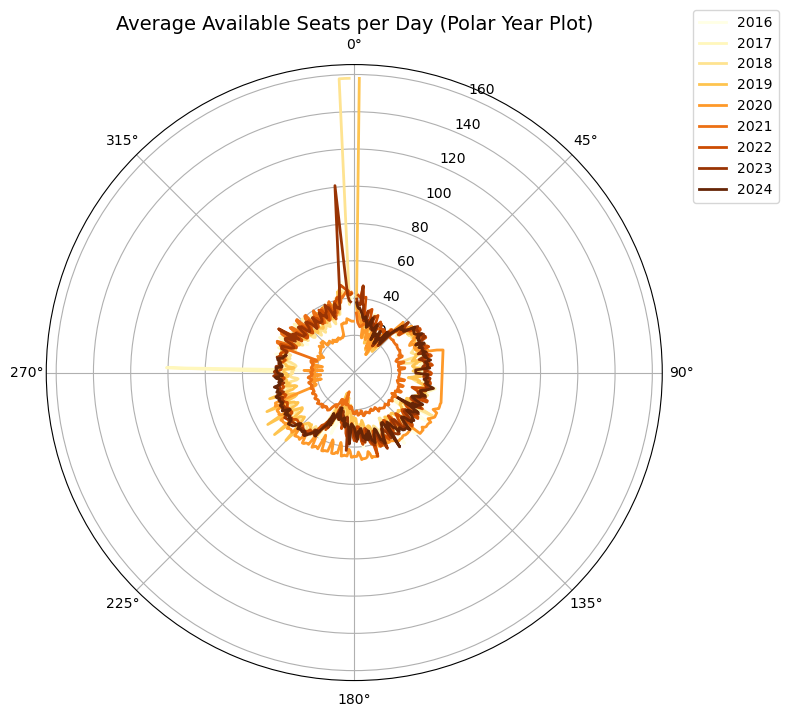

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- Preprocessing -----------------------------------------------------------

df = seat_estimates.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Add year and day-of-year
df['year'] = df['timestamp'].dt.year
df['doy']  = df['timestamp'].dt.dayofyear

# Compute average freeseats per day for each year
daily_avg = (
    df.groupby(['year','doy'])['freeseats']
      .mean()
      .reset_index()
)

# Set up the polar plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='polar')

# Full circle
max_doy = 366  # to handle leap years gracefully
theta = 2 * np.pi * daily_avg['doy'] / max_doy

# --- Color settings: darker brown each year ---------------------------------

years = sorted(daily_avg['year'].unique())
cmap = mpl.cm.get_cmap('YlOrBr', len(years))   # yellow→brown colormap

# Normalize colors so darker = later years
norm = mpl.colors.Normalize(vmin=min(years), vmax=max(years))

# --- Plot --------------------------------------------------------------------

for i, y in enumerate(years):
    ydf = daily_avg[daily_avg['year'] == y]

    theta = 2 * np.pi * ydf['doy'] / max_doy
    r = ydf['freeseats']

    ax.plot(theta, r,
            color=cmap(norm(y)),
            linewidth=2,
            label=str(y))

# Formatting
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title("Average freeseats per Day (Polar Year Plot)", fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.show()


/tmp/nix-shell.0m4KtF/ipykernel_62121/586656289.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('YlOrBr', len(normal_years))


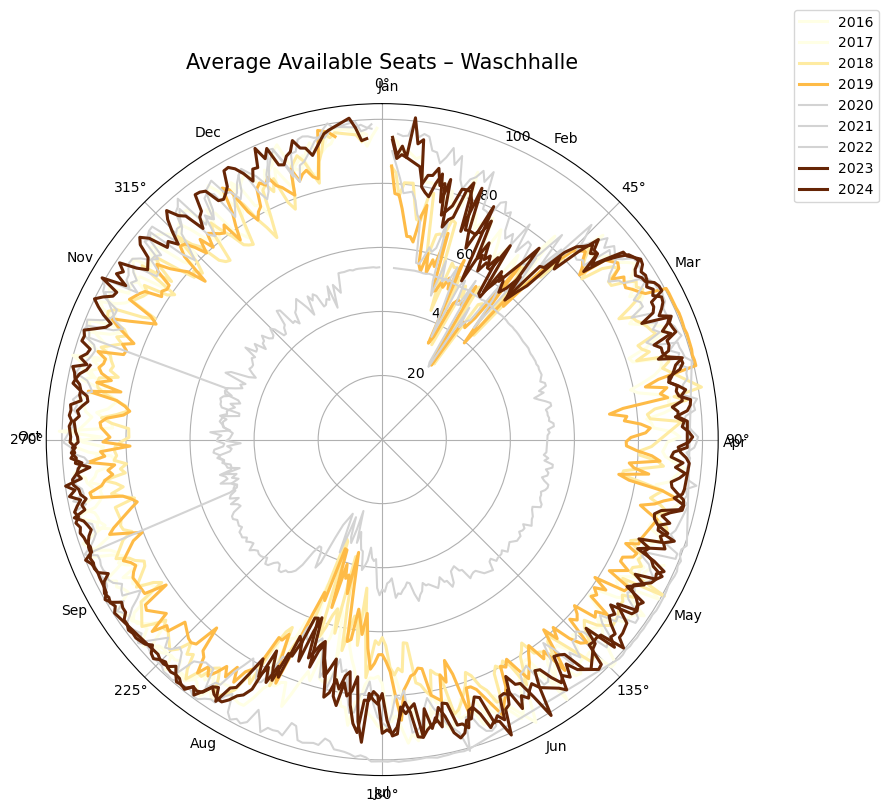

In [16]:
# Waschhalle only

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- Filter ---------------------------------------------------------------
df = seat_estimates.copy()
df = df[df['location_id'] == 15]   # <— only Waschhalle rows
df['timestamp'] = pd.to_datetime(df['timestamp'])

# --- Preprocessing --------------------------------------------------------
df['year'] = df['timestamp'].dt.year
df['doy']  = df['timestamp'].dt.dayofyear

# Avg per day
daily_avg = (
    df.groupby(['year','doy'])['freeseats']
      .mean()
      .reset_index()
)

# --- Plot ---------------------------------------------------------------
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='polar')
# --- Plot --------------------------------------------------------------------

exclude_years = {2020, 2021, 2022, 2024}

years = sorted(daily_avg['year'].unique())

# Brownish colormap (only for non-excluded years)
normal_years = [y for y in years if y not in exclude_years]
cmap = mpl.cm.get_cmap('YlOrBr', len(normal_years))
norm = mpl.colors.Normalize(vmin=min(normal_years), vmax=max(normal_years))

for y in years:
    ydf = daily_avg[daily_avg['year'] == y]
    theta = 2 * np.pi * ydf['doy'] / max_doy
    r = ydf['freeseats']

    # --- Color selection -----------------------------------------------------
    if y in exclude_years:
        color = "lightgray"         # or "gray", "#AAAAAA", etc.
        lw = 1.5
    else:
        color = cmap(norm(y))
        lw = 2.2

    ax.plot(theta, r, color=color, linewidth=lw, label=str(y))


# --- Month labels ---------------------------------------------------------

# Use the first year available for month conversion
example_year = years[0]
month_starts = pd.date_range(start=f"{example_year}-01-01", 
                             end=f"{example_year}-12-01", 
                             freq='MS')

# Add month labels at the right angles
for dt in month_starts:
    doy = dt.timetuple().tm_yday
    theta = 2 * np.pi * doy / max_doy
    ax.text(theta, ax.get_rmax()*1.05, dt.strftime("%b"),
            ha='center', va='center', fontsize=10)

# Orientation
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

ax.set_title("Average Available Seats – Waschhalle", fontsize=15)
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.15))

plt.tight_layout()
plt.show()


/tmp/nix-shell.0m4KtF/ipykernel_62121/281051611.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('YlOrBr', len(normal_years))


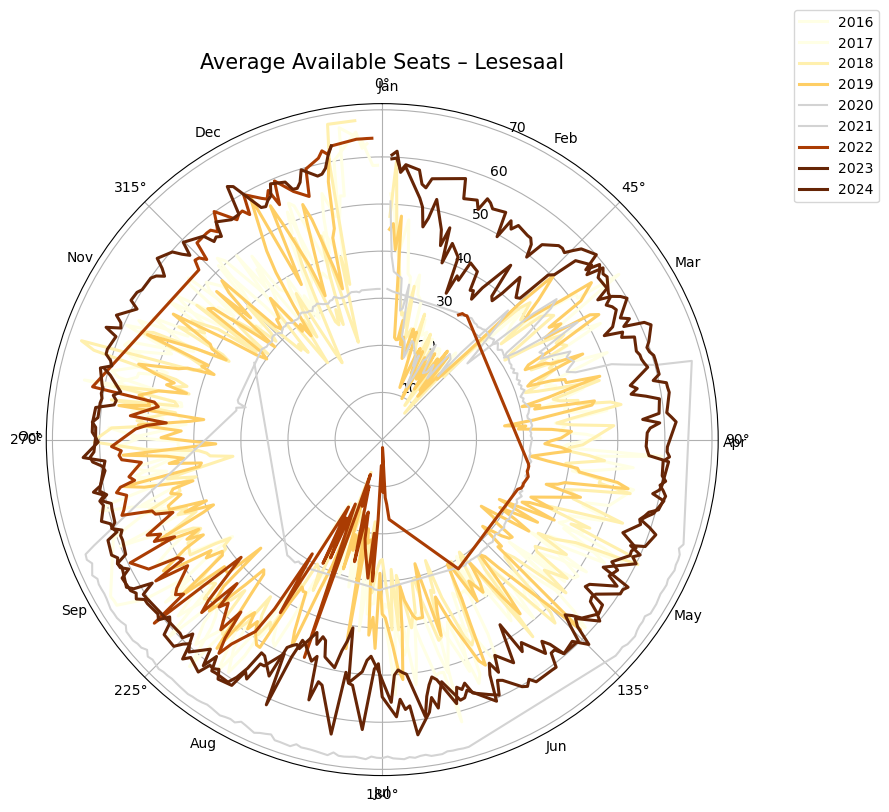

In [18]:
# Lesesaal only

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- Filter ---------------------------------------------------------------
df = seat_estimates.copy()
df = df[df['location_id'] == 3]   # <— only Lesesaal rows
df['timestamp'] = pd.to_datetime(df['timestamp'])

# --- Preprocessing --------------------------------------------------------
df['year'] = df['timestamp'].dt.year
df['doy']  = df['timestamp'].dt.dayofyear

# Avg per day
daily_avg = (
    df.groupby(['year','doy'])['freeseats']
      .mean()
      .reset_index()
)

# --- Plot ---------------------------------------------------------------
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='polar')
# --- Plot --------------------------------------------------------------------

exclude_years = {2020, 2021}

years = sorted(daily_avg['year'].unique())

# Brownish colormap (only for non-excluded years)
normal_years = [y for y in years if y not in exclude_years]
cmap = mpl.cm.get_cmap('YlOrBr', len(normal_years))
norm = mpl.colors.Normalize(vmin=min(normal_years), vmax=max(normal_years))

for y in years:
    ydf = daily_avg[daily_avg['year'] == y]
    theta = 2 * np.pi * ydf['doy'] / max_doy
    r = ydf['freeseats']

    # --- Color selection -----------------------------------------------------
    if y in exclude_years:
        color = "lightgray"         # or "gray", "#AAAAAA", etc.
        lw = 1.5
    else:
        color = cmap(norm(y))
        lw = 2.2

    ax.plot(theta, r, color=color, linewidth=lw, label=str(y))


# --- Month labels ---------------------------------------------------------

# Use the first year available for month conversion
example_year = years[0]
month_starts = pd.date_range(start=f"{example_year}-01-01", 
                             end=f"{example_year}-12-01", 
                             freq='MS')

# Add month labels at the right angles
for dt in month_starts:
    doy = dt.timetuple().tm_yday
    theta = 2 * np.pi * doy / max_doy
    ax.text(theta, ax.get_rmax()*1.05, dt.strftime("%b"),
            ha='center', va='center', fontsize=10)

# Orientation
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

ax.set_title("Average Available Seats – Lesesaal", fontsize=15)
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.15))

plt.tight_layout()
plt.show()


## Over a Day
### per location

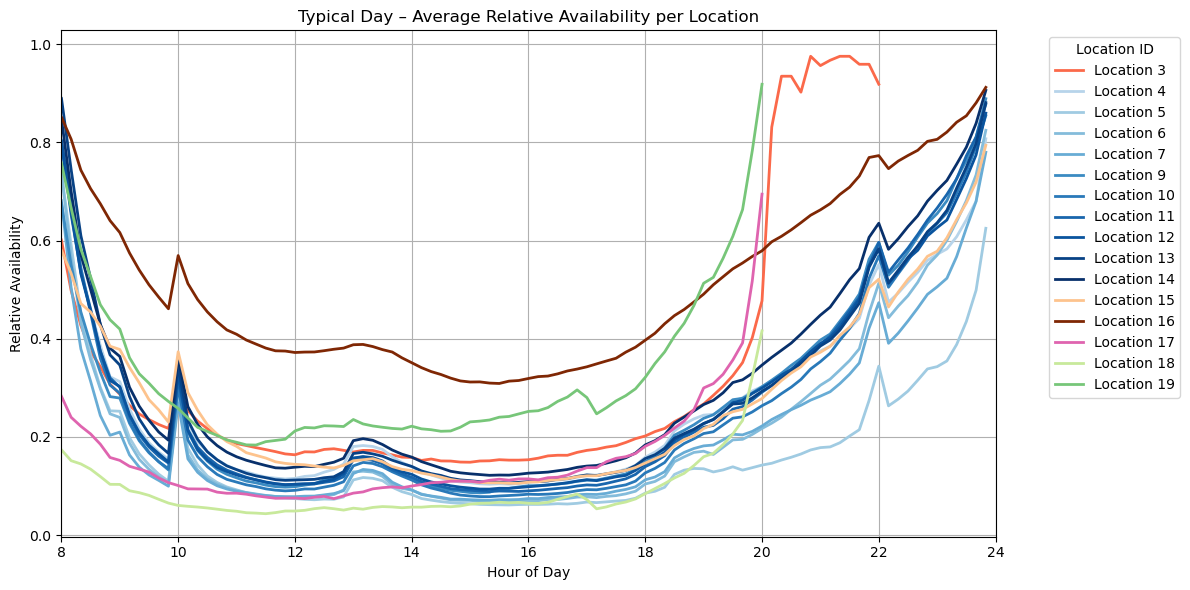

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1) Define color groups ---
group1 = list(range(4, 15))   # 4–14
group2 = [15, 16]
group3 = [18, 19]             # Greens now yellowish
bright_lines = [3, 17]        # IDs that need bright lines

# --- 2) Helper to get shades ---
def get_shades(cmap_name, n, min_val=0.3, max_val=1.0):
    """Return n shades from a colormap between min_val and max_val."""
    cmap = plt.colormaps[cmap_name]
    values = np.linspace(min_val, max_val, n)
    return [cmap(v) for v in values]

# --- 3) Build color dictionary ---
color_map = {}

# IDs 4–14 → Blues
for i, loc in enumerate(group1):
    color_map[loc] = get_shades('Blues', len(group1))[i]

# IDs 15–16 → Oranges
for i, loc in enumerate(group2):
    color_map[loc] = get_shades('Oranges', len(group2))[i]

# IDs 18–19 → Light yellowish greens
for i, loc in enumerate(group3):
    color_map[loc] = get_shades('YlGn', len(group3), min_val=0.3, max_val=0.5)[i]

# IDs 3 & 17 → Bright lines
color_map[3] = plt.colormaps['Reds'](0.5)      # bright red
color_map[17] = plt.colormaps['PuRd'](0.5)     # pinkish

# --- 4) Compute "typical day" ---
seat_estimates['time_of_day_hours'] = (
    seat_estimates['timestamp_10min'].dt.hour +
    seat_estimates['timestamp_10min'].dt.minute / 60 +
    seat_estimates['timestamp_10min'].dt.second / 3600
)

avg_day = (
    seat_estimates
    .groupby(['location_id', 'time_of_day_hours'])['relative_availability']
    .mean()
    .reset_index()
)

# --- 5) Plot ---
fig, ax = plt.subplots(figsize=(12, 6))

for loc_id, df_loc in avg_day.groupby('location_id'):
    color = color_map.get(loc_id, 'gray')  # fallback color
    ax.plot(df_loc['time_of_day_hours'],
            df_loc['relative_availability'],
            label=f"Location {loc_id}",
            color=color,
            linewidth=2)

ax.set_title("Typical Day – Average Relative Availability per Location")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Relative Availability")
ax.set_xlim(8, 24)
ax.legend(title="Location ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
avg_day = (
    seat_estimates
    .groupby(['location_id', 'time_of_day_hours'])['freeseats']
    .mean()
    .reset_index()
)

# --- 5) Plot ---
fig, ax = plt.subplots(figsize=(12, 6))

for loc_id, df_loc in avg_day.groupby('location_id'):
    color = color_map.get(loc_id, 'gray')  # fallback color
    ax.plot(df_loc['time_of_day_hours'],
            df_loc['freeseats'],
            label=f"Location {loc_id}",
            color=color,
            linewidth=2)

ax.set_title("Typical Day – Average Free Seats per Location")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Free Seats")
ax.set_xlim(8, 24)
ax.legend(title="Location ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### per building

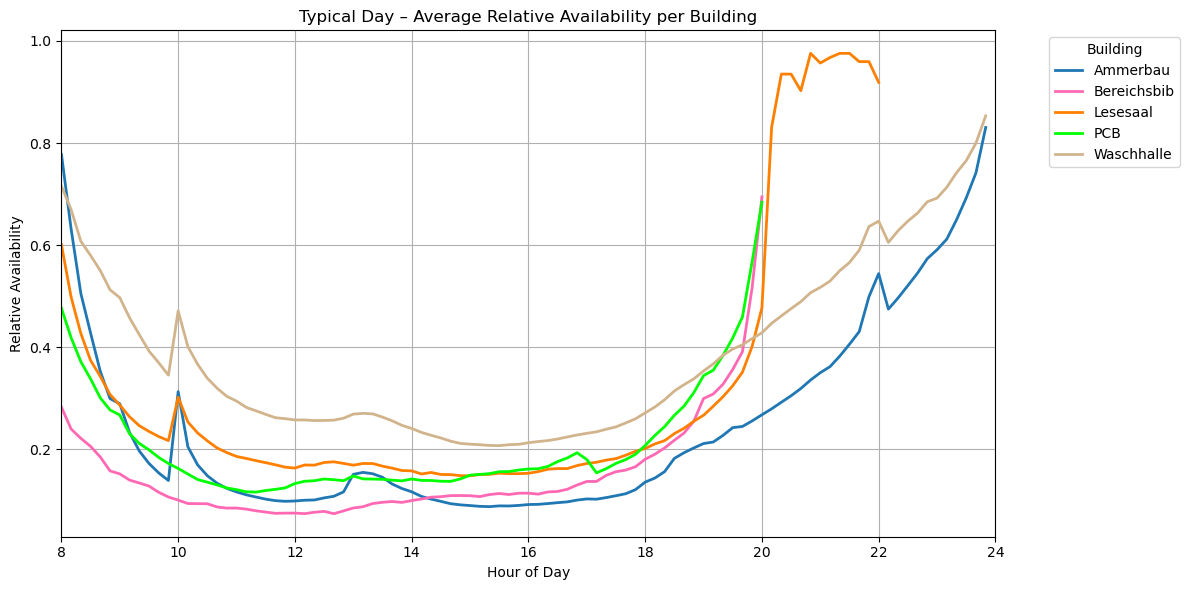

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Define building colors ---
building_colors = {
    "Lesesaal": "#FF8000",   # orange
    "Ammerbau": "#1f77b4",   # blue (Matplotlib default blue)
    "Waschhalle": "#D2B48C", # light brown (tan)
    "Bereichsbib": "#FF69B4",# pink
    "PCB": "#00FF00",         # bright green
}

# --- 2) Compute "typical day" ---
seat_estimates['time_of_day_hours'] = (
    seat_estimates['timestamp_10min'].dt.hour +
    seat_estimates['timestamp_10min'].dt.minute / 60 +
    seat_estimates['timestamp_10min'].dt.second / 3600
)

avg_day_building = (
    seat_estimates
    .groupby(['location_building', 'time_of_day_hours'])['relative_availability']
    .mean()
    .reset_index()
)

# --- 3) Plot ---
fig, ax = plt.subplots(figsize=(12, 6))

for building, df_build in avg_day_building.groupby('location_building'):
    color = building_colors.get(building, 'gray')  # fallback gray if not listed
    ax.plot(df_build['time_of_day_hours'],
            df_build['relative_availability'],
            label=building,
            color=color,
            linewidth=2)

ax.set_title("Typical Day – Average Relative Availability per Building")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Relative Availability")
ax.set_xlim(8, 24)
ax.legend(title="Building", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


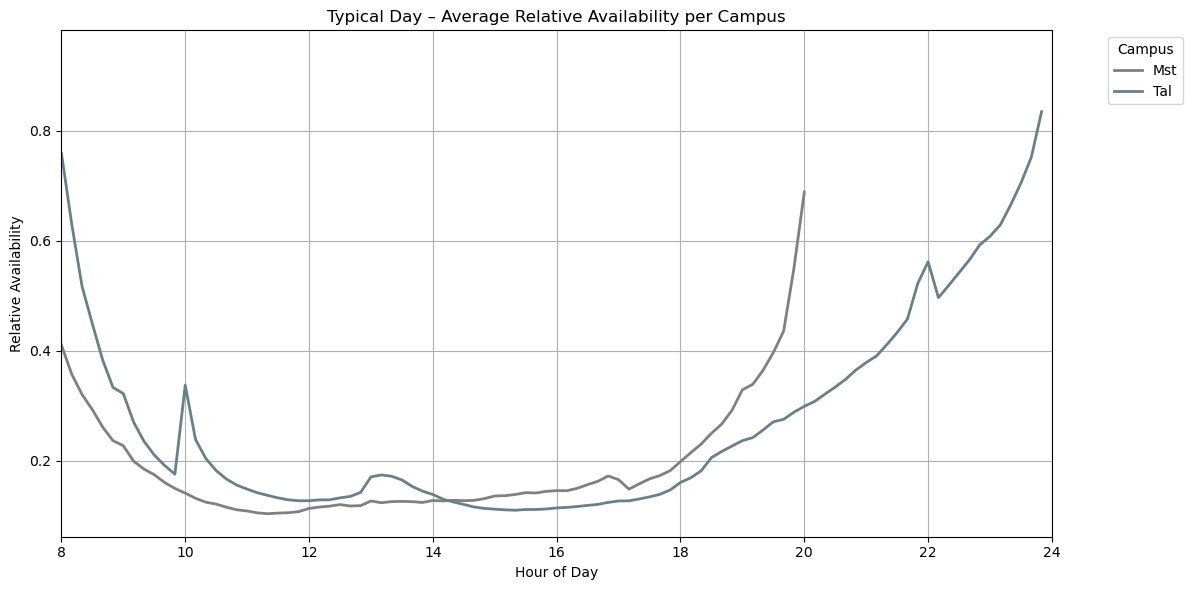

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Define campus colours ---
campus_colors = {
    "Tal": "#698089",   # grey
    "MST": "##2d434b",   # different gray
}

# --- 2) Compute "typical day" ---
seat_estimates['time_of_day_hours'] = (
    seat_estimates['timestamp_10min'].dt.hour +
    seat_estimates['timestamp_10min'].dt.minute / 60 +
    seat_estimates['timestamp_10min'].dt.second / 3600
)

avg_day_campus = (
    seat_estimates
    .groupby(['location_campus', 'time_of_day_hours'])['relative_availability']
    .mean()
    .reset_index()
)

# --- 3) Plot ---
fig, ax = plt.subplots(figsize=(12, 6))

for campus, df_build in avg_day_campus.groupby('location_campus'):
    color = campus_colors.get(campus, 'gray')  # fallback gray if not listed
    ax.plot(df_build['time_of_day_hours'],
            df_build['relative_availability'],
            label=campus,
            color=color,
            linewidth=2)

ax.set_title("Typical Day – Average Relative Availability per Campus")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Relative Availability")
ax.set_xlim(8, 24)
ax.legend(title="Campus", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


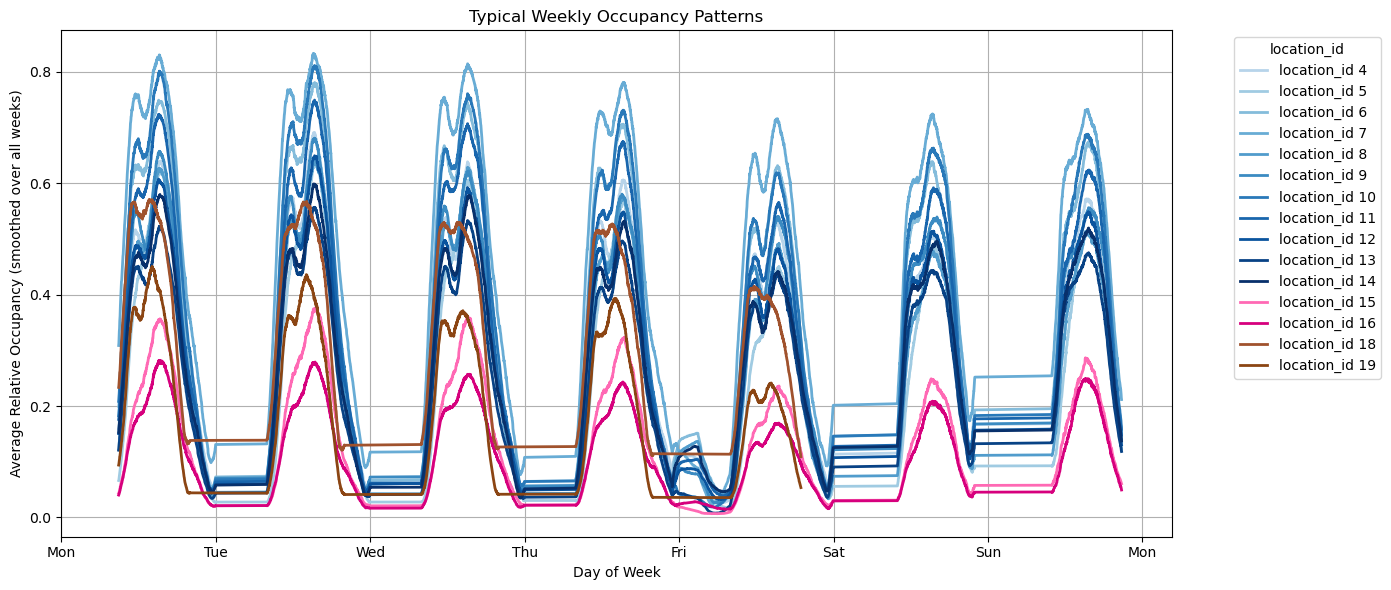

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# --- Location groups ---
blue_ids  = list(range(4, 15))   # 4–14
pink_ids  = [15, 16]
brown_ids = [18, 19]

all_ids = blue_ids + pink_ids + brown_ids

# Filter relevant data
df = seat_estimates[seat_estimates["location_id"].isin(all_ids)].copy()

# Extract day-of-week and time-of-day
df["day_of_week"] = df["timestamp_10min"].dt.dayofweek  # Monday=0
df["hour"]        = df["timestamp_10min"].dt.hour
df["minute"]      = df["timestamp_10min"].dt.minute

# Minutes since start of week
df["minute_of_week"] = df["day_of_week"]*24*60 + df["hour"]*60 + df["minute"]

# Compute weekly average across all years
avg_week = (
    df.groupby(["location_id", "minute_of_week"])["relative_occupancy"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(14, 6))
ROLLING_WINDOW = 100 # in 5-min increments

# --- Color palettes ---
blue_cmap = mpl.colormaps["Blues"]
blue_colors = [blue_cmap(i) for i in np.linspace(0.3, 1.0, len(blue_ids))]

pink_colors = ["#ff69b4", "#d6007d"]
brown_colors = ["#a0522d", "#8b4513"]

def plot_group(ids, colors):
    for loc, color in zip(ids, colors):
        data = avg_week[avg_week["location_id"] == loc].sort_values("minute_of_week")
        y_smoothed = data["relative_occupancy"].rolling(ROLLING_WINDOW, center=True).mean()
        plt.plot(
            data["minute_of_week"],
            y_smoothed,
            label=f"location_id {loc}",
            color=color,
            linewidth=2
        )

# Plot each group
plot_group(blue_ids, blue_colors)
plot_group(pink_ids, pink_colors)
plot_group(brown_ids, brown_colors)

# X-axis formatting: show days
ticks = np.arange(0, 7*24*60 + 1, 24*60)  # every day
tick_labels = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun","Mon"]
plt.xticks(ticks, tick_labels)

plt.xlabel("Day of Week")
plt.ylabel("Average Relative Occupancy (smoothed over all weeks)")
plt.title("Typical Weekly Occupancy Patterns")
plt.legend(title="location_id", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



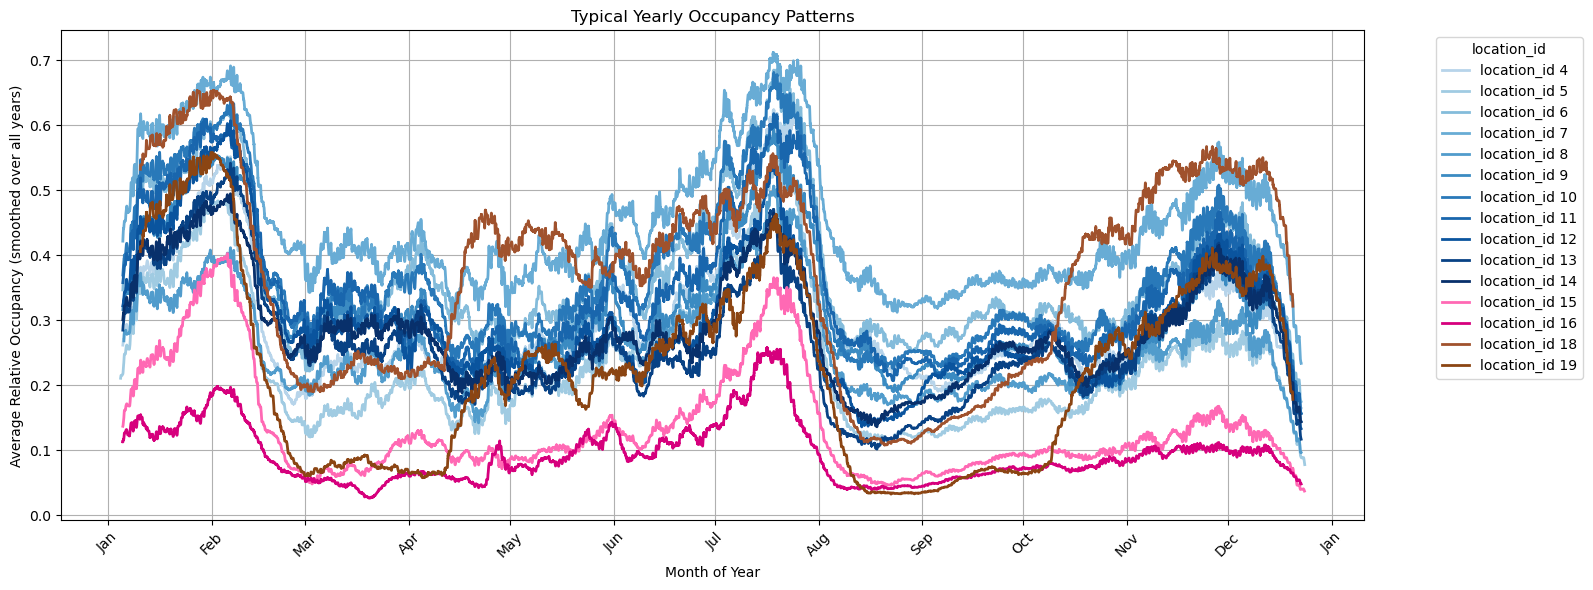

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# --- Location groups ---
blue_ids  = list(range(4, 15))   # 4–14
pink_ids  = [15, 16]
brown_ids = [18, 19]

all_ids = blue_ids + pink_ids + brown_ids

# Filter relevant data
df = seat_estimates[seat_estimates["location_id"].isin(all_ids)].copy()

# Extract day-of-year, hour, minute
df["day_of_year"] = df["timestamp_10min"].dt.dayofyear  # 1–366
df["hour"]        = df["timestamp"].dt.hour
df["minute"]      = df["timestamp"].dt.minute

# Minutes since start of year
df["minute_of_year"] = (df["day_of_year"] - 1)*24*60 + df["hour"]*60 + df["minute"]

# Compute average occupancy per minute_of_year across all years
avg_year = (
    df.groupby(["location_id", "minute_of_year"])["relative_occupancy"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(16, 6))
ROLLING_WINDOW = 2000  # in 5-min increments (~35 min smoothing)

# --- Color palettes ---
blue_cmap = mpl.colormaps["Blues"]
blue_colors = [blue_cmap(i) for i in np.linspace(0.3, 1.0, len(blue_ids))]

pink_colors = ["#ff69b4", "#d6007d"]
brown_colors = ["#a0522d", "#8b4513"]

def plot_group(ids, colors):
    for loc, color in zip(ids, colors):
        data = avg_year[avg_year["location_id"] == loc].sort_values("minute_of_year")
        y_smoothed = data["relative_occupancy"].rolling(ROLLING_WINDOW, center=True).mean()
        plt.plot(
            data["minute_of_year"],
            y_smoothed,
            label=f"location_id {loc}",
            color=color,
            linewidth=2
        )

# Plot groups
plot_group(blue_ids, blue_colors)
plot_group(pink_ids, pink_colors)
plot_group(brown_ids, brown_colors)

# X-axis: mark months for readability
months = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335, 366]  # approximate start day of month
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec","Jan"]

# Convert to minutes
month_ticks = [(d-1)*24*60 for d in months]
plt.xticks(month_ticks, month_labels, rotation=45)

plt.xlabel("Month of Year")
plt.ylabel("Average Relative Occupancy (smoothed over all years)")
plt.title("Typical Yearly Occupancy Patterns")
plt.legend(title="location_id", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


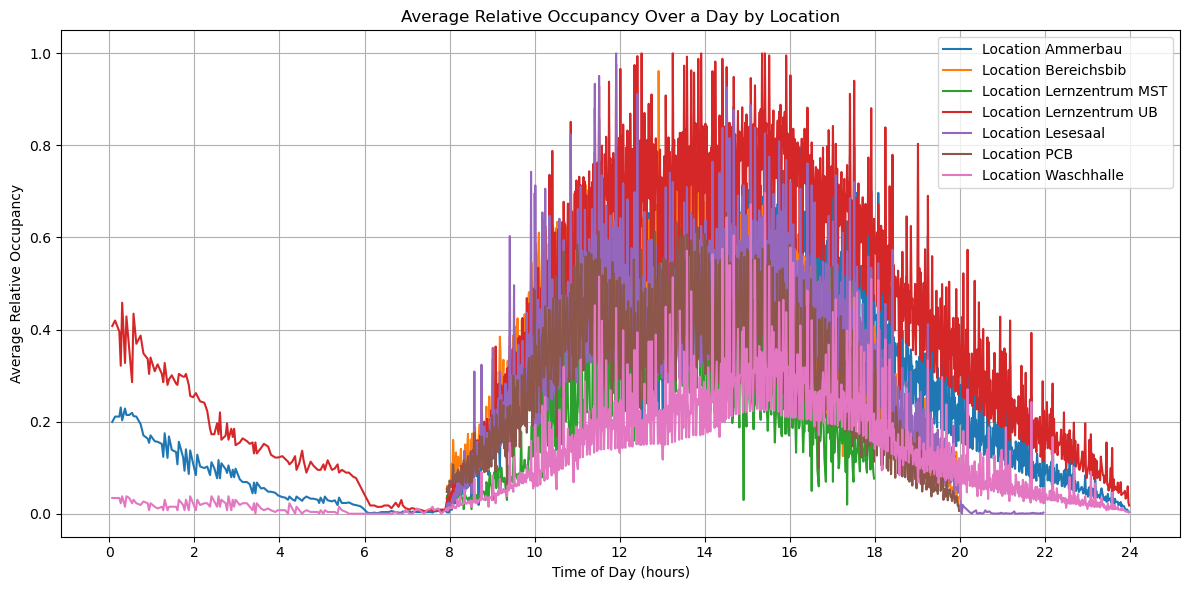

In [11]:

# Convert timestamp to time-of-day in fractional hours
seat_est_aggregated_merged["time_of_day_hours"] = seat_est_aggregated_merged["timestamp"].dt.hour + seat_est_aggregated_merged["timestamp"].dt.minute / 60

# Compute average relative occupancy per time-of-day and location
avg_day = (
    seat_est_aggregated_merged.groupby(["location_id", "time_of_day_hours"])["relative_occupancy"]
      .mean()
      .reset_index()
)

# Plot
plt.figure(figsize=(12, 6))

for location, group in avg_day.groupby("location_id"):
    plt.plot(group["time_of_day_hours"], group["relative_occupancy"], label=f"Location {location}")

plt.xlabel("Time of Day (hours)")
plt.ylabel("Average Relative Occupancy")
plt.title("Average Relative Occupancy Over a Day by Location")
plt.xticks(range(0, 25, 2))  # optional: tick every 2 hours
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


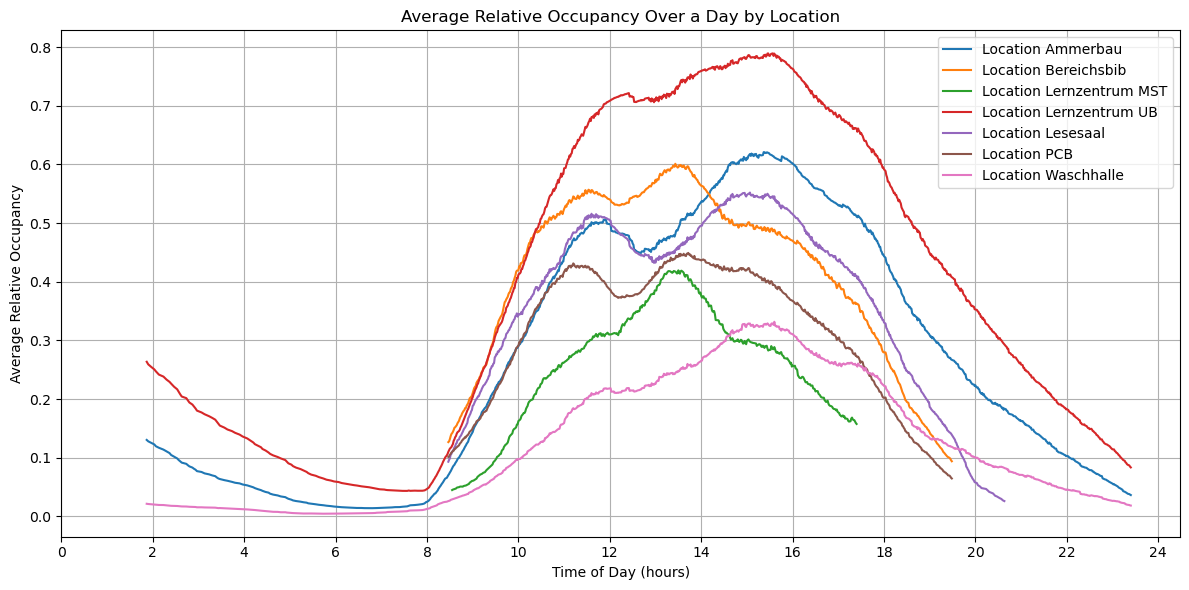

In [12]:

# Convert timestamp to time-of-day in fractional hours
seat_est_aggregated_merged["time_of_day_hours"] = seat_est_aggregated_merged["timestamp"].dt.hour + seat_est_aggregated_merged["timestamp"].dt.minute / 60

# Compute average relative occupancy per time-of-day and location
avg_day = (
    seat_est_aggregated_merged.groupby(["location_id", "time_of_day_hours"])["relative_occupancy"]
      .mean()
      .reset_index()
)

# Apply 5-minute rolling mean on the averaged curve (per location)
avg_day["relative_occupancy"] = (
    avg_day.groupby("location_id")["relative_occupancy"]
           .rolling(60, center=True)
           .mean()
           .reset_index(level=0, drop=True)
)


# Plot
plt.figure(figsize=(12, 6))

for location, group in avg_day.groupby("location_id"):
    plt.plot(group["time_of_day_hours"], group["relative_occupancy"], label=f"Location {location}")

plt.xlabel("Time of Day (hours)")
plt.ylabel("Average Relative Occupancy")
plt.title("Average Relative Occupancy Over a Day by Location")
plt.xticks(range(0, 25, 2))  # optional: tick every 2 hours
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'seat_est_aggregated_merged' is not defined

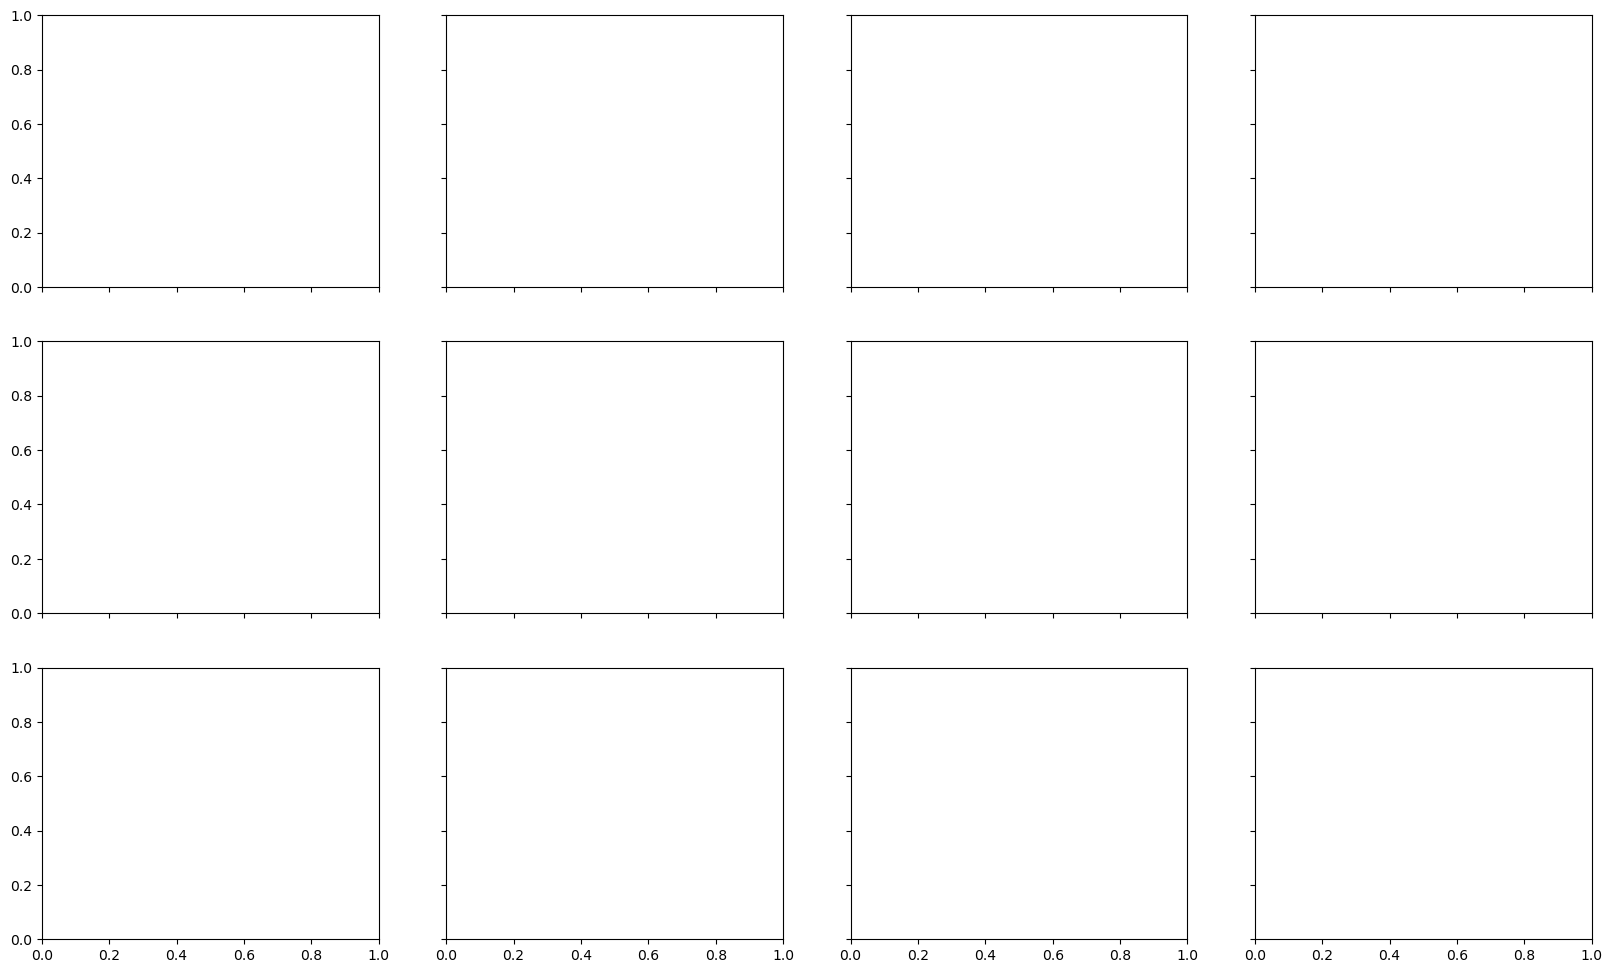

In [1]:
import matplotlib.pyplot as plt
import numpy as np

ROLLING_WINDOW = 12  # adjust depending on data frequency (e.g., 12*5min = 1 hour smoothing)

# Prepare subplots: 3 rows × 4 columns
fig, axes = plt.subplots(3, 4, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

for month in range(1, 13):
    ax = axes[month-1]
    
    # Filter data for the month
    df_month = seat_est_aggregated_merged[seat_est_aggregated_merged["timestamp"].dt.month == month].copy()
    
    if df_month.empty:
        ax.set_title(f"Month {month} (no data)")
        continue
    
    # Time-of-day in fractional hours
    df_month["time_of_day_hours"] = df_month["timestamp"].dt.hour + df_month["timestamp"].dt.minute / 60
    
    # Compute average occupancy per location
    avg_day = (
        df_month.groupby(["location_id", "time_of_day_hours"])["relative_occupancy"]
                .mean()
                .reset_index()
    )
    
    # Apply rolling mean per location
    avg_day["relative_occupancy"] = (
        avg_day.groupby("location_id")["relative_occupancy"]
               .rolling(ROLLING_WINDOW, center=True)
               .mean()
               .reset_index(level=0, drop=True)
    )
    
    # Plot each location using default colors
    for i, (location, group) in enumerate(avg_day.groupby("location_id")):
        ax.plot(group["time_of_day_hours"], group["relative_occupancy"], label=f"{location}")
    
    # Axes formatting
    ax.set_title(pd.to_timestamp(f"2023-{month:02d}-01").strftime("%B"))
    ax.set_xticks(range(7, 25, 4))
    ax.set_xlabel("Time of Day (hours)")
    ax.set_ylabel("Avg Relative Occupancy")
    ax.grid(True)

# Single legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Location ID", bbox_to_anchor=(1.02, 0.95), loc="upper left")

plt.tight_layout()
plt.show()


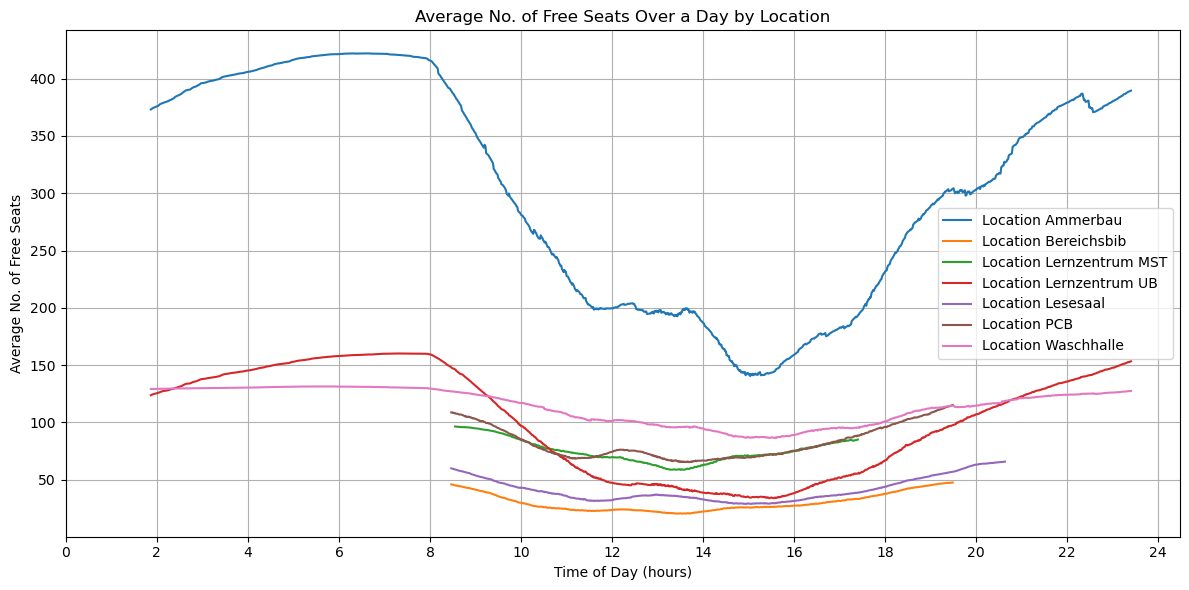

In [21]:

# Compute average free seats per time-of-day and location
avg_day = (
    seat_est_aggregated_merged.groupby(["location_id", "time_of_day_hours"])["freeseats"]
      .mean()
      .reset_index()
)

# Apply 5-minute rolling mean on the averaged curve (per location)
avg_day["freeseats"] = (
    avg_day.groupby("location_id")["freeseats"]
           .rolling(60, center=True)
           .mean()
           .reset_index(level=0, drop=True)
)


# Plot
plt.figure(figsize=(12, 6))

for location, group in avg_day.groupby("location_id"):
    plt.plot(group["time_of_day_hours"], group["freeseats"], label=f"Location {location}")

plt.xlabel("Time of Day (hours)")
plt.ylabel("Average No. of Free Seats")
plt.title("Average No. of Free Seats Over a Day by Location")
plt.xticks(range(0, 25, 2))  # optional: tick every 2 hours
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


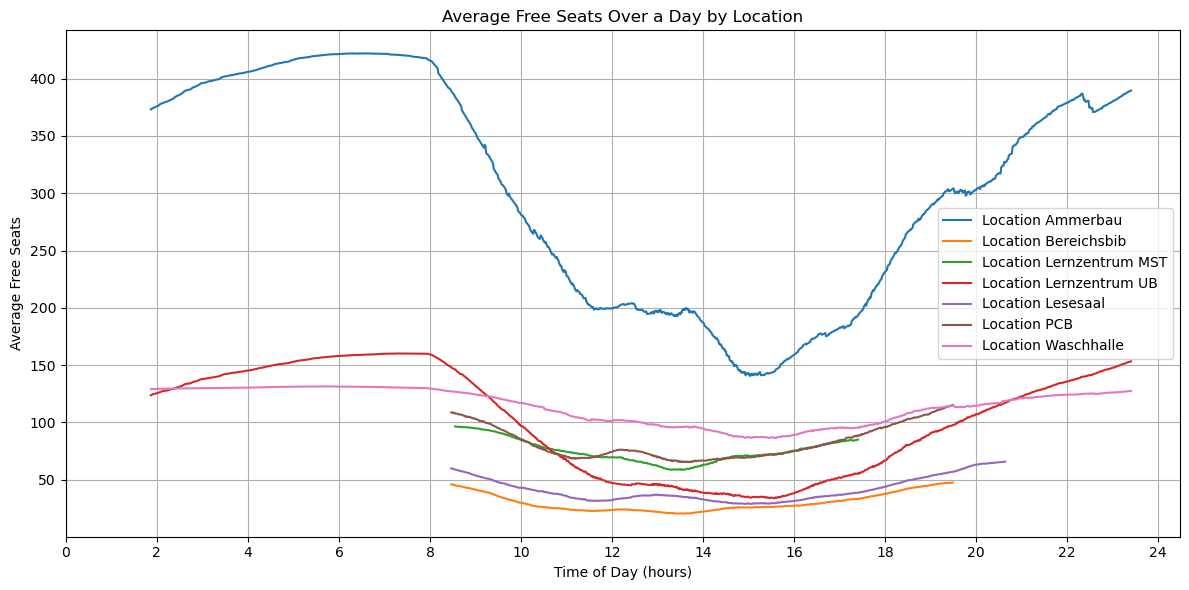

In [14]:

# Convert timestamp to time-of-day in fractional hours
seat_est_aggregated_merged["time_of_day_hours"] = seat_est_aggregated_merged["timestamp"].dt.hour + seat_est_aggregated_merged["timestamp"].dt.minute / 60

# Compute average relative occupancy per time-of-day and location
avg_day = (
    seat_est_aggregated_merged.groupby(["location_id", "time_of_day_hours"])["freeseats"]
      .mean()
      .reset_index()
)

# Apply 5-minute rolling mean on the averaged curve (per location)
avg_day["freeseats"] = (
    avg_day.groupby("location_id")["freeseats"]
           .rolling(60, center=True)
           .mean()
           .reset_index(level=0, drop=True)
)


# Plot
plt.figure(figsize=(12, 6))

for location, group in avg_day.groupby("location_id"):
    plt.plot(group["time_of_day_hours"], group["freeseats"], label=f"Location {location}")

plt.xlabel("Time of Day (hours)")
plt.ylabel("Average Free Seats")
plt.title("Average Free Seats Over a Day by Location")
plt.xticks(range(0, 25, 2))  # optional: tick every 2 hours
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


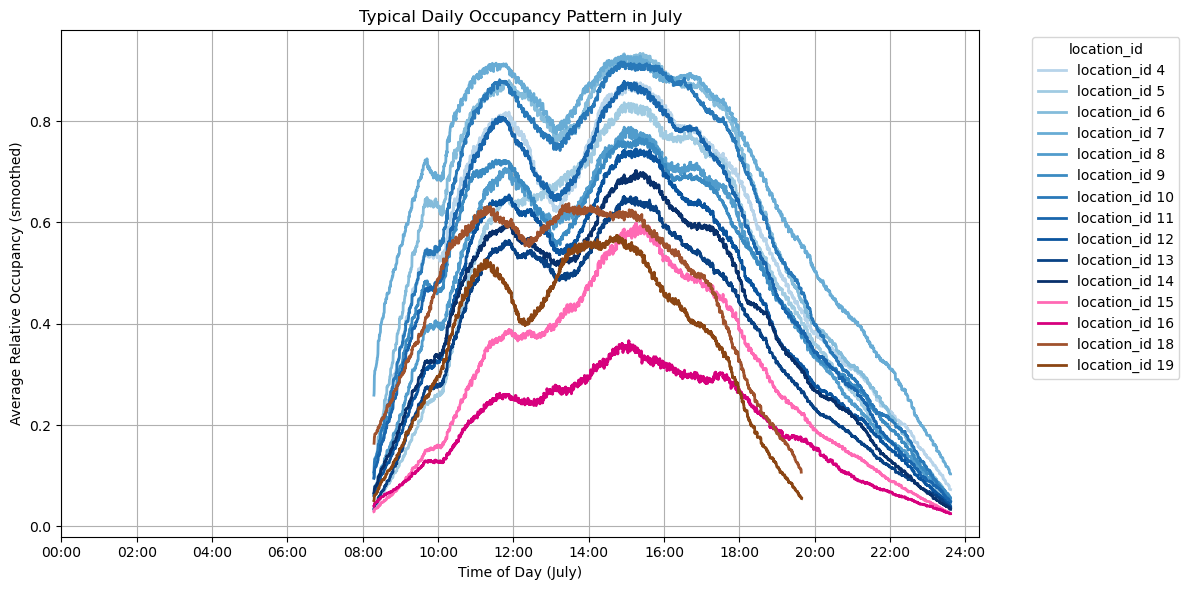

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# --- Location groups ---
blue_ids  = list(range(4, 15))   # 4–14
pink_ids  = [15, 16]
brown_ids = [18, 19]

all_ids = blue_ids + pink_ids + brown_ids

# Filter relevant data
df = seat_estimates[seat_estimates["location_id"].isin(all_ids)].copy()

# Filter only July
df = df[df["timestamp"].dt.month == 7]

# Extract time-of-day
df["time"] = df["timestamp"].dt.time

# Convert time to minutes since midnight
def time_to_minutes(t):
    return t.hour*60 + t.minute + t.second/60

df["minute_of_day"] = df["time"].apply(time_to_minutes)

# Compute average relative occupancy by location_id and minute_of_day
avg_day = (
    df.groupby(["location_id", "minute_of_day"])["relative_occupancy"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(12, 6))
ROLLING_WINDOW = 300  # smoothing (~35 min)

# --- Color palettes ---
blue_cmap = mpl.colormaps["Blues"]
blue_colors = [blue_cmap(i) for i in np.linspace(0.3, 1.0, len(blue_ids))]

pink_colors = ["#ff69b4", "#d6007d"]
brown_colors = ["#a0522d", "#8b4513"]

def plot_group(ids, colors):
    for loc, color in zip(ids, colors):
        data = avg_day[avg_day["location_id"] == loc].sort_values("minute_of_day")
        y_smoothed = data["relative_occupancy"].rolling(ROLLING_WINDOW, center=True).mean()
        plt.plot(
            data["minute_of_day"],
            y_smoothed,
            label=f"location_id {loc}",
            color=color,
            linewidth=2
        )

# Plot each group
plot_group(blue_ids, blue_colors)
plot_group(pink_ids, pink_colors)
plot_group(brown_ids, brown_colors)

# X-axis formatting: show every 2 hours
ticks = np.arange(0, 24*60 + 1, 120)
tick_labels = [f"{t//60:02d}:{t%60:02d}" for t in ticks]
plt.xticks(ticks, tick_labels)

plt.xlabel("Time of Day (July)")
plt.ylabel("Average Relative Occupancy (smoothed)")
plt.title("Typical Daily Occupancy Pattern in July")
plt.legend(title="location_id", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



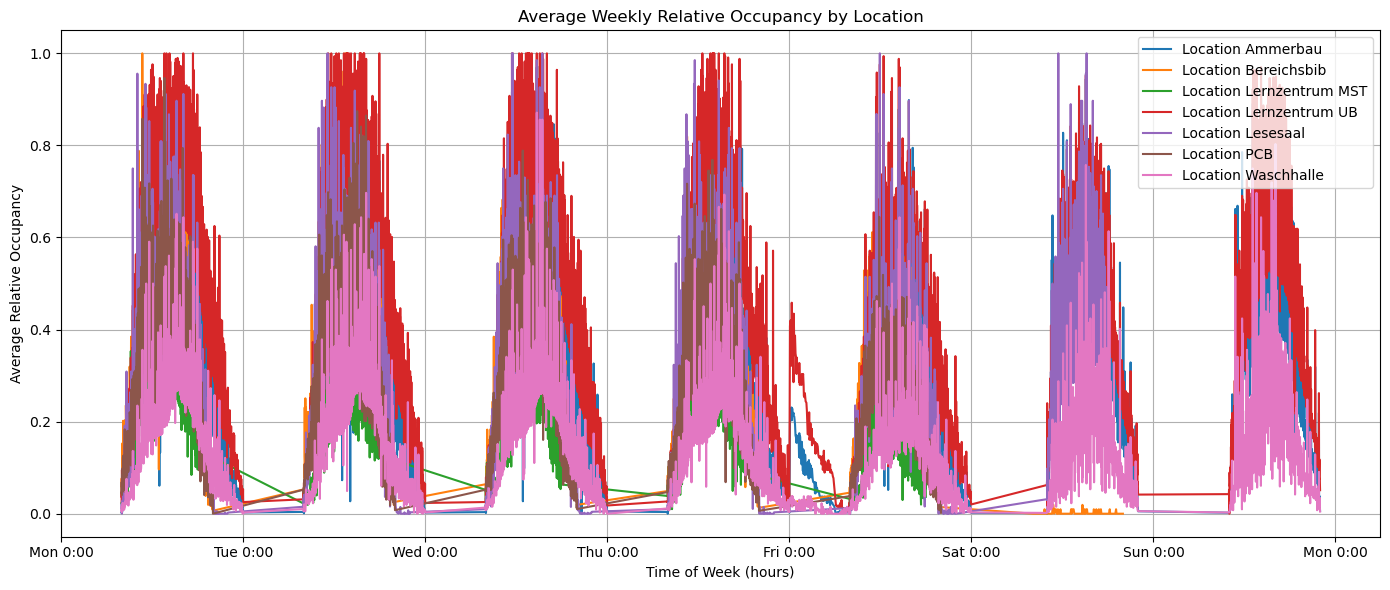

In [15]:


# Compute the time within the week (in hours)
# Monday 00:00 = 0, Sunday 23:59 = 167.9833...
seat_est_aggregated_merged["time_of_week_hours"] = (
    seat_est_aggregated_merged["timestamp"].dt.dayofweek * 24 + seat_est_aggregated_merged["timestamp"].dt.hour + seat_est_aggregated_merged["timestamp"].dt.minute / 60
)

avg_week = (
    seat_est_aggregated_merged.groupby(["location_id", "time_of_week_hours"])["relative_occupancy"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(14, 6))

for location, group in avg_week.groupby("location_id"):
    plt.plot(group["time_of_week_hours"], group["relative_occupancy"], label=f"Location {location}")

plt.xlabel("Time of Week (hours)")
plt.ylabel("Average Relative Occupancy")
plt.title("Average Weekly Relative Occupancy by Location")
plt.xticks(
    ticks=[0, 24, 48, 72, 96, 120, 144, 168],
    labels=["Mon 0:00","Tue 0:00","Wed 0:00","Thu 0:00","Fri 0:00","Sat 0:00","Sun 0:00","Mon 0:00"]
)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


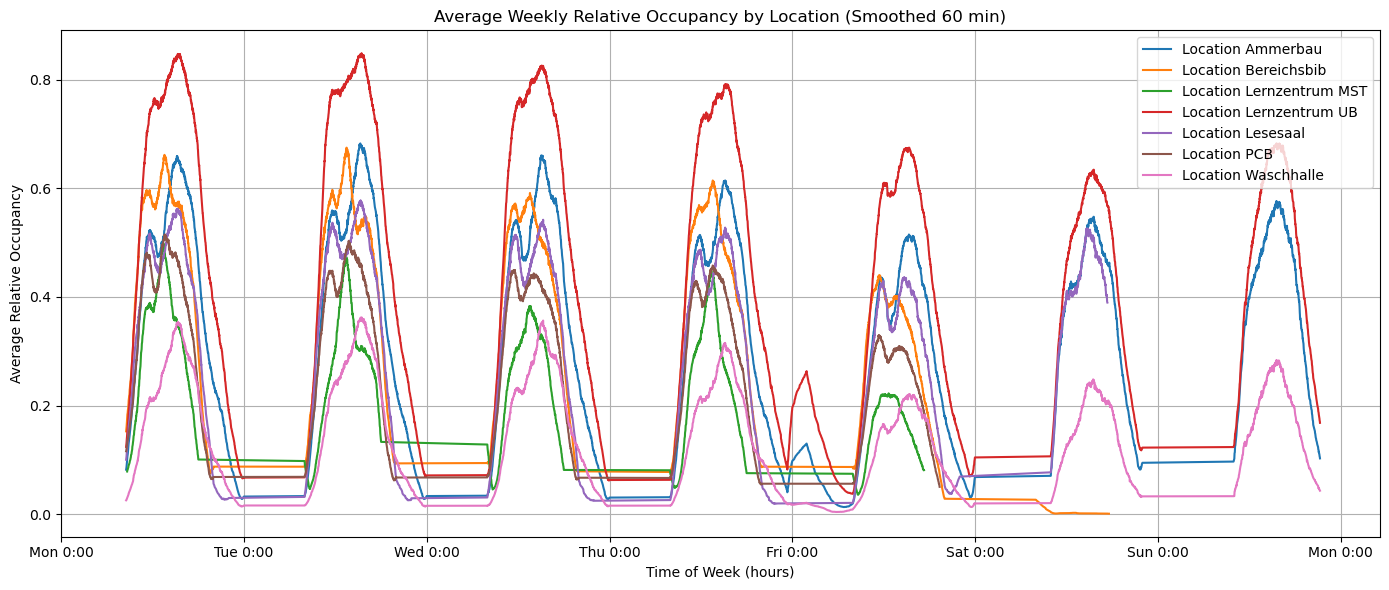

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Compute time of week in hours
seat_est_aggregated_merged["time_of_week_hours"] = seat_est_aggregated_merged["timestamp"].dt.dayofweek * 24 + seat_est_aggregated_merged["timestamp"].dt.hour + seat_est_aggregated_merged["timestamp"].dt.minute / 60

# Average across all weeks per location
avg_week = seat_est_aggregated_merged.groupby(["location_id", "time_of_week_hours"])["relative_occupancy"].mean().reset_index()

# Rolling 60-minute mean after averaging
# Adjust window depending on your time resolution (here assuming hourly points)
avg_week["relative_occupancy"] = (
    avg_week.groupby("location_id")["relative_occupancy"]
            .rolling(60, center=True)
            .mean()
            .reset_index(level=0, drop=True)
)


# Plot per location
plt.figure(figsize=(14, 6))
for location, group in avg_week.groupby("location_id"):
    plt.plot(group["time_of_week_hours"], group["relative_occupancy"], label=f"Location {location}")

# Plot overall average in black

plt.xlabel("Time of Week (hours)")
plt.ylabel("Average Relative Occupancy")
plt.title("Average Weekly Relative Occupancy by Location (Smoothed 60 min)")
plt.xticks(
    ticks=[0, 24, 48, 72, 96, 120, 144, 168],
    labels=["Mon 0:00","Tue 0:00","Wed 0:00","Thu 0:00","Fri 0:00","Sat 0:00","Sun 0:00","Mon 0:00"]
)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Typical data frequency: 6.0 minutes


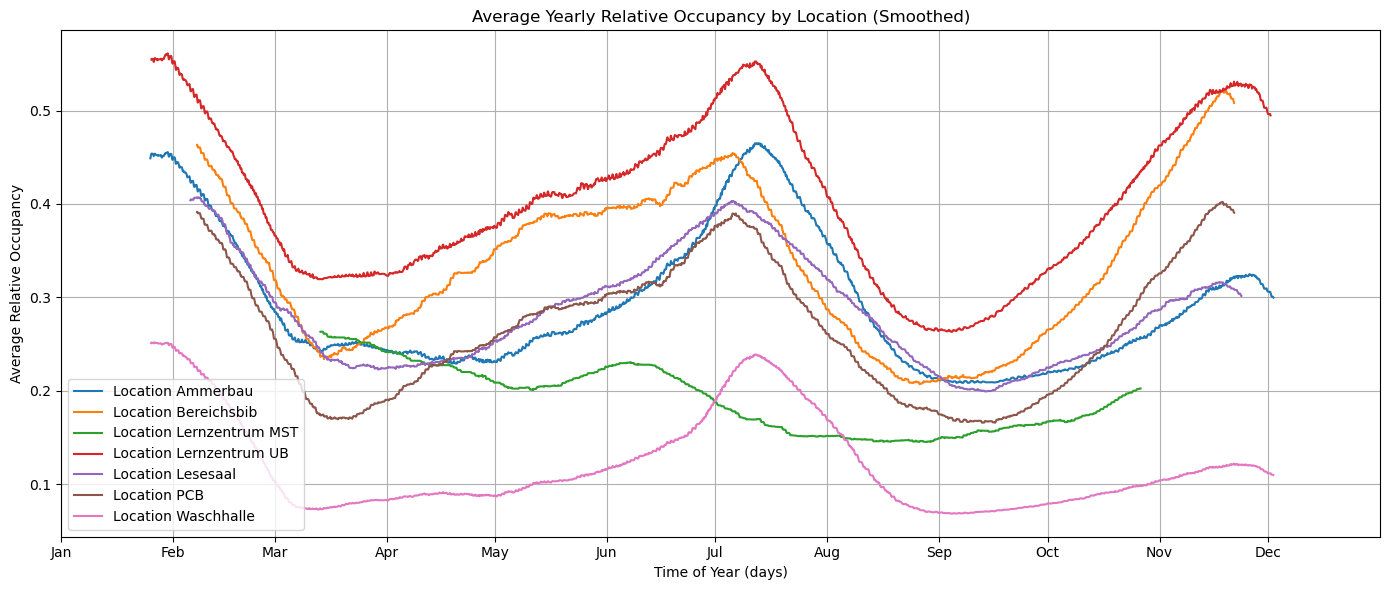

In [17]:

# Ensure timestamp is datetime
seat_est_aggregated_merged["timestamp"] = pd.to_datetime(seat_est_aggregated_merged["timestamp"])
seat_est_aggregated_merged = seat_est_aggregated_merged.sort_values("timestamp")

# Detect typical data frequency in minutes (safe version)
time_diffs = seat_est_aggregated_merged["timestamp"].diff().dropna()
time_diffs = time_diffs[time_diffs > pd.Timedelta(0)]  # remove zero differences (duplicates)
typical_diff_minutes = time_diffs.mode()[0].total_seconds() / 60
print(f"Typical data frequency: {typical_diff_minutes} minutes")

# Convert timestamp to time-of-year in fractional days
seat_est_aggregated_merged["time_of_year_days"] = seat_est_aggregated_merged["timestamp"].dt.dayofyear \
                          + seat_est_aggregated_merged["timestamp"].dt.hour / 24 \
                          + seat_est_aggregated_merged["timestamp"].dt.minute / (24*60)

# Average across all years per location
avg_year = seat_est_aggregated_merged.groupby(["location_id", "time_of_year_days"])["relative_occupancy"].mean().reset_index()

# Calculate rolling window size in points for 60-minute mean
window_size = int(100000 / typical_diff_minutes)
if window_size < 1:
    window_size = 1

# Apply rolling mean after averaging
avg_year["relative_occupancy"] = (
    avg_year.groupby("location_id")["relative_occupancy"]
            .rolling(window_size, center=True)
            .mean()
            .reset_index(level=0, drop=True)
)

# Month positions in day-of-year (approximate for non-leap year)
month_days = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]  # Jan 1, Feb 1, ..., Dec 1
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]


# Plot per location
plt.figure(figsize=(14, 6))
for location, group in avg_year.groupby("location_id"):
    plt.plot(group["time_of_year_days"], group["relative_occupancy"], label=f"Location {location}")

# Plot overall average in black

plt.xlabel("Time of Year (days)")
plt.ylabel("Average Relative Occupancy")
plt.title("Average Yearly Relative Occupancy by Location (Smoothed)")
plt.xticks(ticks=month_days, labels=month_labels)
plt.xlim(1, 366)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



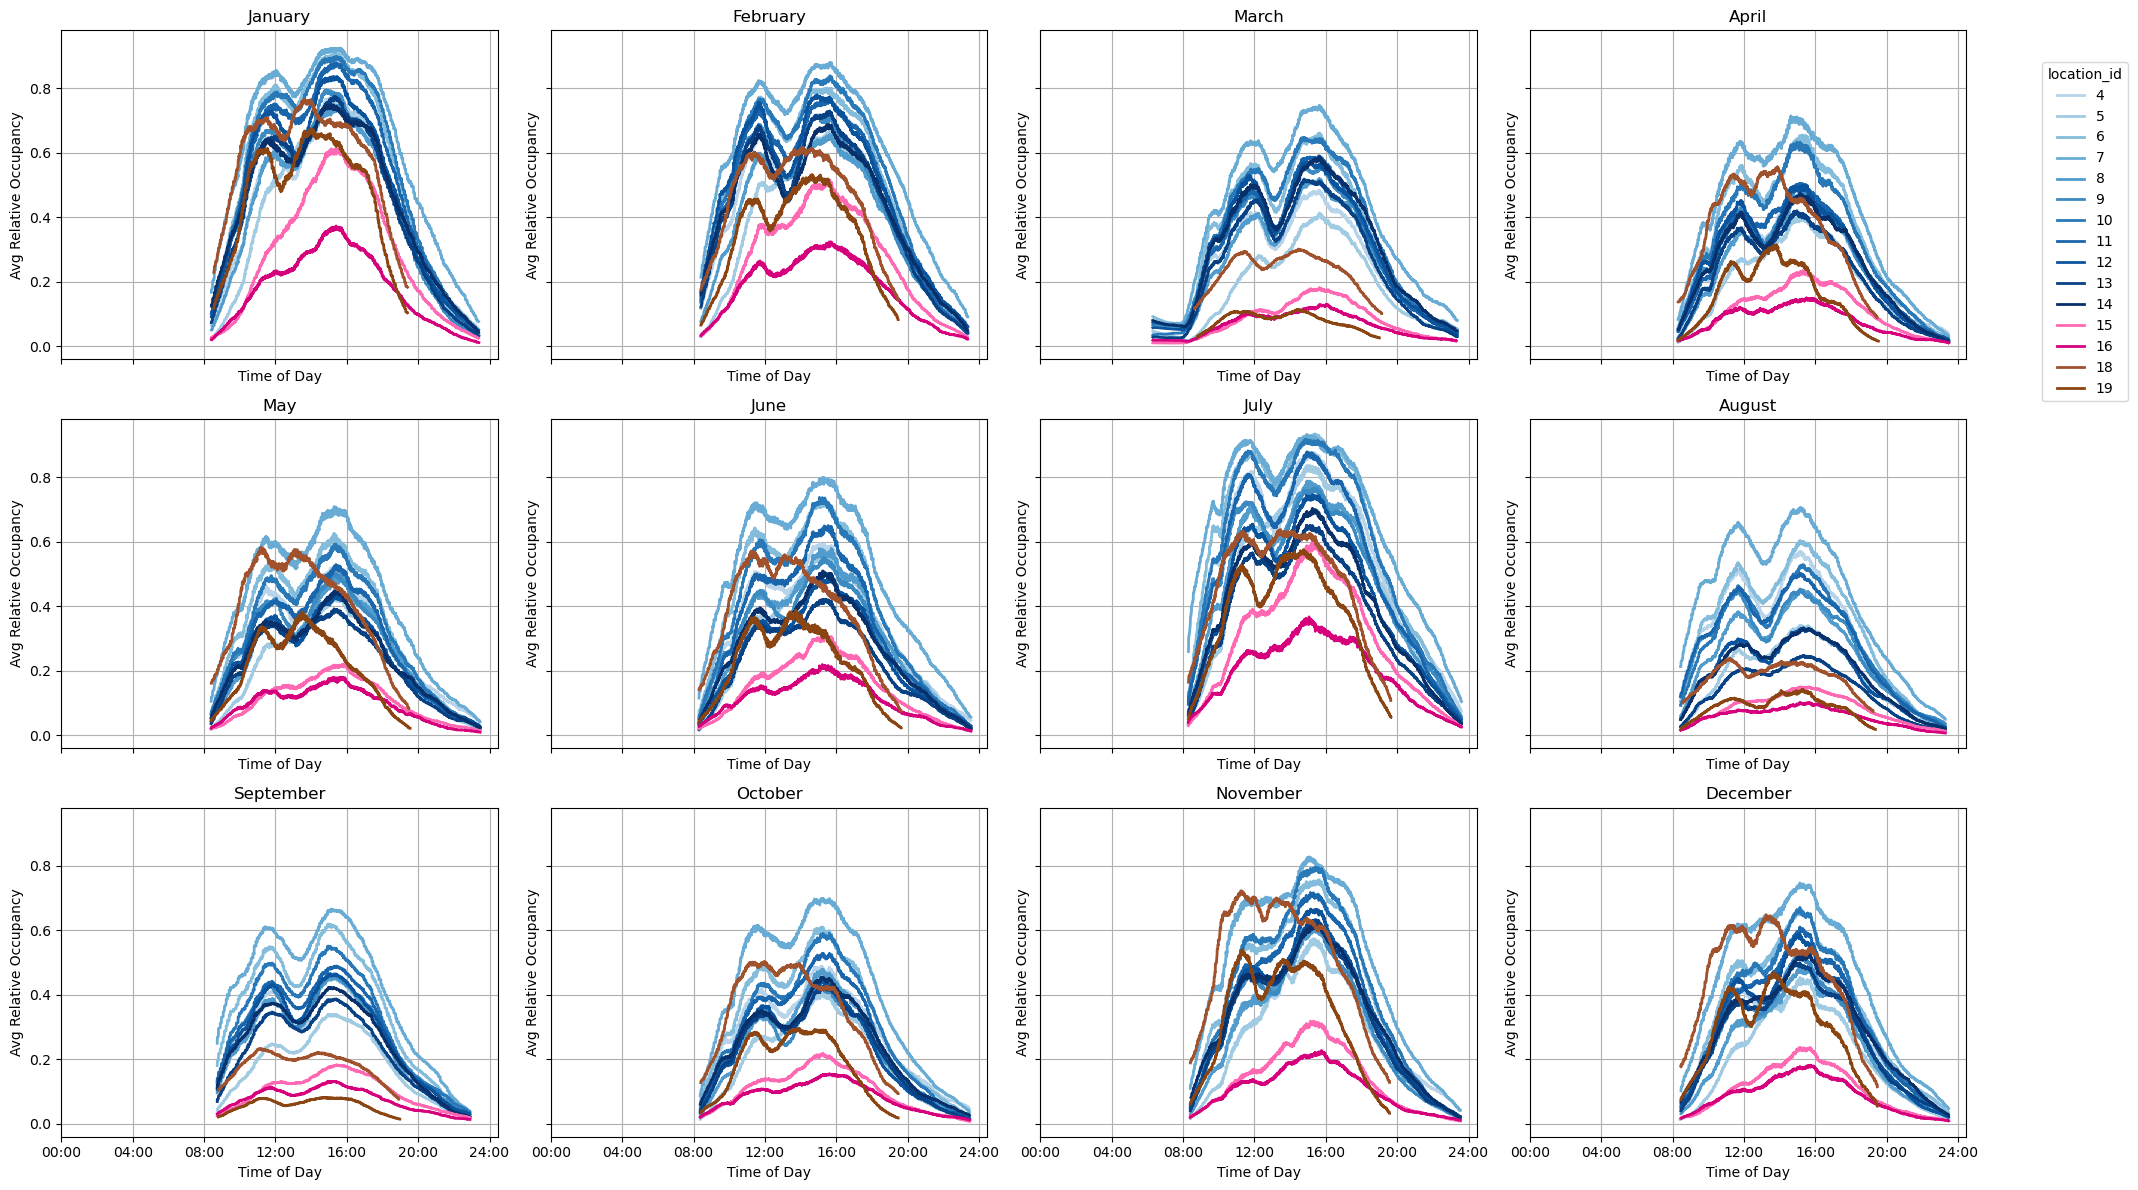

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# --- Location groups ---
blue_ids  = list(range(4, 15))   # 4–14
pink_ids  = [15, 16]
brown_ids = [18, 19]

all_ids = blue_ids + pink_ids + brown_ids

# Filter relevant data
df = seat_estimates[seat_estimates["location_id"].isin(all_ids)].copy()

# Extract time-of-day
df["time"] = df["timestamp"].dt.time

# Convert time to minutes since midnight
def time_to_minutes(t):
    return t.hour*60 + t.minute + t.second/60

df["minute_of_day"] = df["time"].apply(time_to_minutes)

ROLLING_WINDOW = 300  # smoothing (~35 min)

# --- Color palettes ---
blue_cmap = mpl.colormaps["Blues"]
blue_colors = [blue_cmap(i) for i in np.linspace(0.3, 1.0, len(blue_ids))]

pink_colors = ["#ff69b4", "#d6007d"]
brown_colors = ["#a0522d", "#8b4513"]

def plot_group(data_group, ids, colors, ax):
    for loc, color in zip(ids, colors):
        data = data_group[data_group["location_id"] == loc].sort_values("minute_of_day")
        y_smoothed = data["relative_occupancy"].rolling(ROLLING_WINDOW, center=True).mean()
        ax.plot(
            data["minute_of_day"],
            y_smoothed,
            label=f"{loc}",
            color=color,
            linewidth=2
        )

# --- Setup 12 subplots ---
fig, axes = plt.subplots(3, 4, figsize=(20, 12), sharey=True, sharex=True)
axes = axes.flatten()

for month in range(1, 13):
    ax = axes[month-1]
    df_month = df[df["timestamp"].dt.month == month]
    
    if df_month.empty:
        ax.set_title(f"Month {month} (no data)")
        continue
    
    # Compute average daily pattern for this month
    avg_month = (
        df_month.groupby(["location_id", "minute_of_day"])["relative_occupancy"]
                .mean()
                .reset_index()
    )
    
    # Plot groups
    plot_group(avg_month, blue_ids, blue_colors, ax)
    plot_group(avg_month, pink_ids, pink_colors, ax)
    plot_group(avg_month, brown_ids, brown_colors, ax)
    
    # X-axis formatting
    ticks = np.arange(0, 24*60 + 1, 240)  # every 4 hours
    tick_labels = [f"{t//60:02d}:{t%60:02d}" for t in ticks]
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)
    
    ax.set_title(pd.to_datetime(f"2023-{month:02d}-01").strftime("%B"))
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Avg Relative Occupancy")

# Single legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="location_id", bbox_to_anchor=(1.02, 0.95), loc="upper left")

plt.tight_layout()
plt.show()


# No Free Seats: An Alternative Attempt at Determining for which Days the SeatAdvisor is Actually Needed

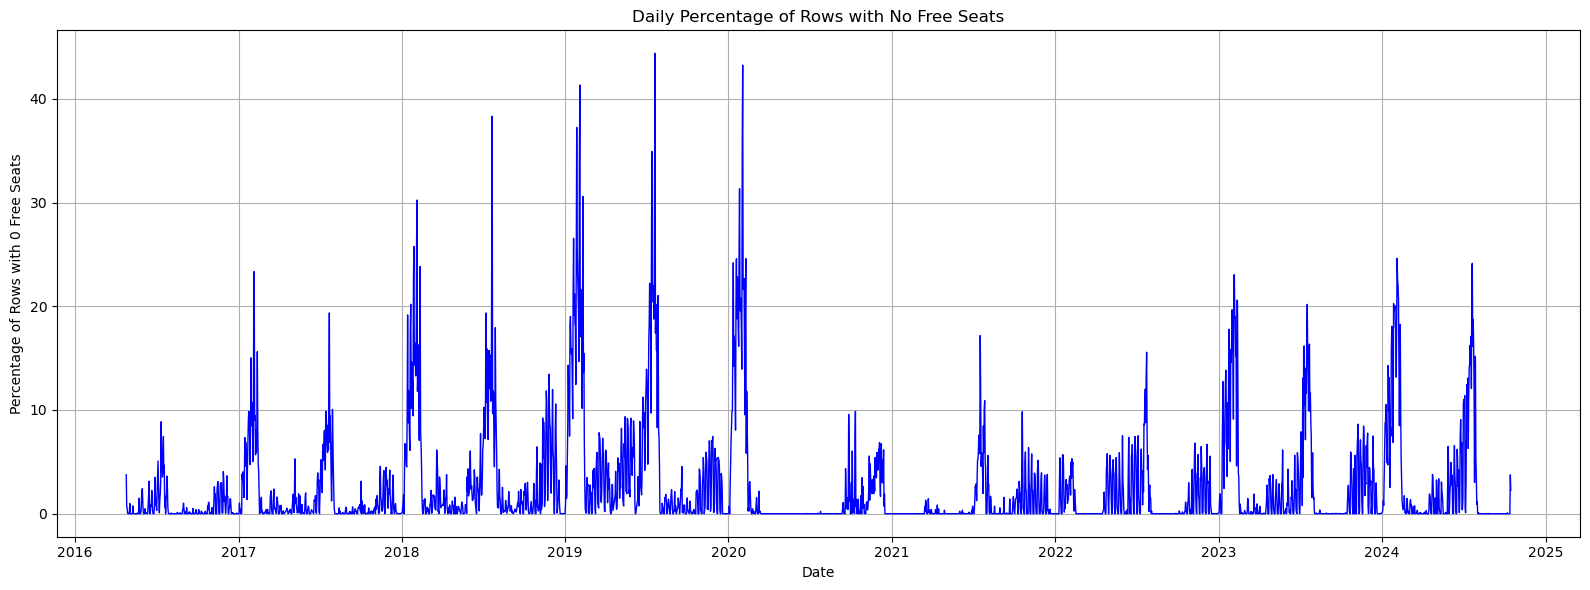

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Make sure timestamp is datetime
df = seat_estimates.copy()
df["date"] = df["timestamp"].dt.date  # extract date (year-month-day)

# Compute fraction of rows with freeseats == 0 per day
daily_zero_frac = (
    df.groupby("date")["freeseats"]
      .apply(lambda x: (x == 0).mean() * 100)  # percentage
      .reset_index(name="percent_zero_freeseats")
)

# Plot
plt.figure(figsize=(16, 6))
plt.plot(daily_zero_frac["date"], daily_zero_frac["percent_zero_freeseats"], color="blue", linewidth=1)
plt.xlabel("Date")
plt.ylabel("Percentage of Rows with 0 Free Seats")
plt.title("Daily Percentage of Rows with No Free Seats")
plt.grid(True)
plt.tight_layout()
plt.show()


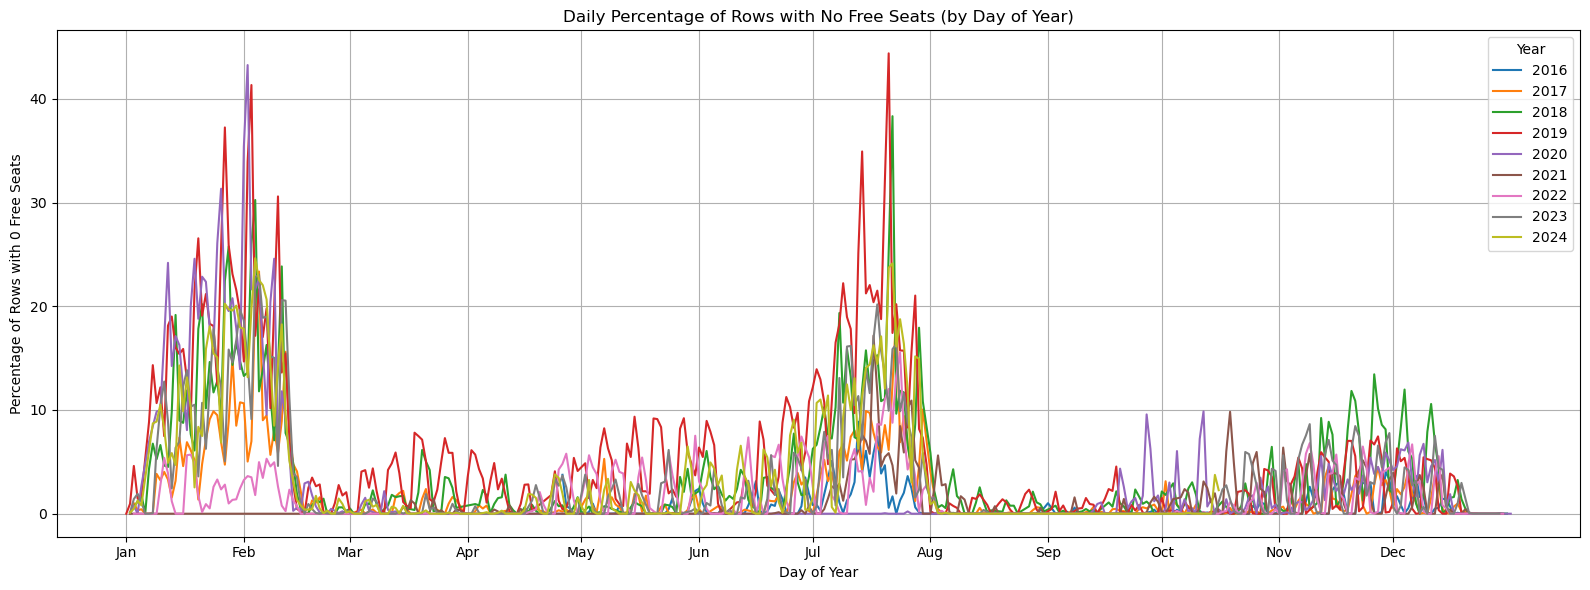

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar

# Copy and prepare data
df = seat_estimates.copy()
df["date"] = df["timestamp"].dt.date
df["day_of_year"] = df["timestamp"].dt.dayofyear  # 1–365 (or 366)
df["year"] = df["timestamp"].dt.year
df["month"] = df["timestamp"].dt.month

# Compute daily percentage of rows with freeseats == 0
daily_zero_frac = (
    df.groupby(["year", "day_of_year"])["freeseats"]
      .apply(lambda x: (x == 0).mean() * 100)
      .reset_index(name="percent_zero_freeseats")
)

# Smooth across 7 days
# daily_zero_frac["percent_zero_freeseats_smooth"] = daily_zero_frac.groupby("year")["percent_zero_freeseats"]\
 #   .rolling(7, center=True).mean().reset_index(level=0, drop=True)

# --- Prepare month labels for x-axis ---
# Use the first day-of-year of each month for labeling
month_starts = df.groupby("month")["day_of_year"].min()
month_labels = [calendar.month_abbr[m] for m in month_starts.index]

# Plot
plt.figure(figsize=(16, 6))
for year, group in daily_zero_frac.groupby("year"):
    plt.plot(group["day_of_year"], group["percent_zero_freeseats"], label=str(year))

plt.xlabel("Day of Year")
plt.ylabel("Percentage of Rows with 0 Free Seats")
plt.title("Daily Percentage of Rows with No Free Seats (by Day of Year)")

# Set month labels
plt.xticks(month_starts.values, month_labels)

plt.grid(True)
plt.legend(title="Year")
plt.tight_layout()
plt.show()


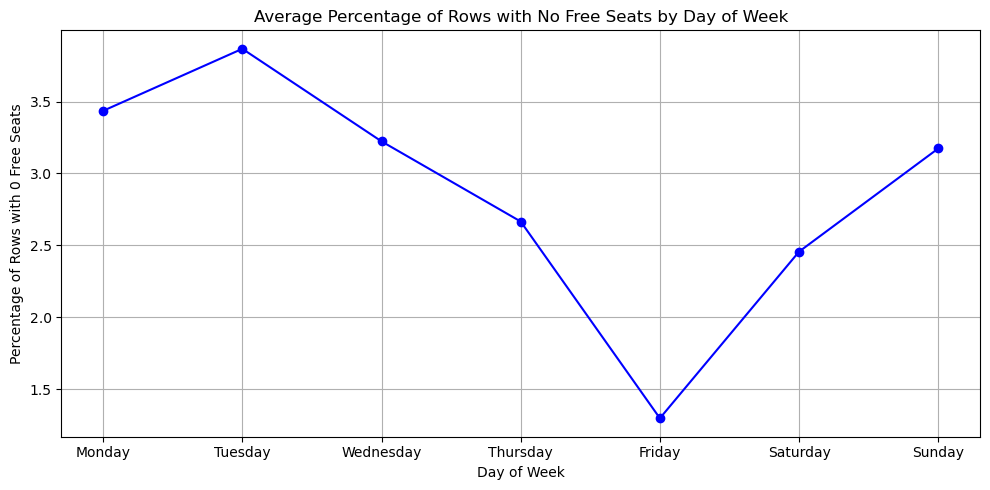

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# Copy data
df = seat_estimates.copy()

# Extract day of week (0=Monday, 6=Sunday)
df["day_of_week_num"] = df["timestamp"].dt.weekday
df["day_of_week_name"] = df["timestamp"].dt.day_name()

# Compute average percentage of rows with freeseats == 0 per day of the week
weekly_zero_frac = (
    df.groupby(["day_of_week_num", "day_of_week_name"])["freeseats"]
      .apply(lambda x: (x == 0).mean() * 100)
      .reset_index(name="percent_zero_freeseats")
)

# Sort by weekday number to ensure Monday -> Sunday order
weekly_zero_frac = weekly_zero_frac.sort_values("day_of_week_num")



# Plot
plt.figure(figsize=(10, 5))
plt.plot(
    weekly_zero_frac["day_of_week_name"],
    weekly_zero_frac["percent_zero_freeseats"],
    marker="o",
    linestyle="-",
    color="blue"
)
plt.xlabel("Day of Week")
plt.ylabel("Percentage of Rows with 0 Free Seats")
plt.title("Average Percentage of Rows with No Free Seats by Day of Week")
plt.grid(True)
plt.tight_layout()
plt.show()


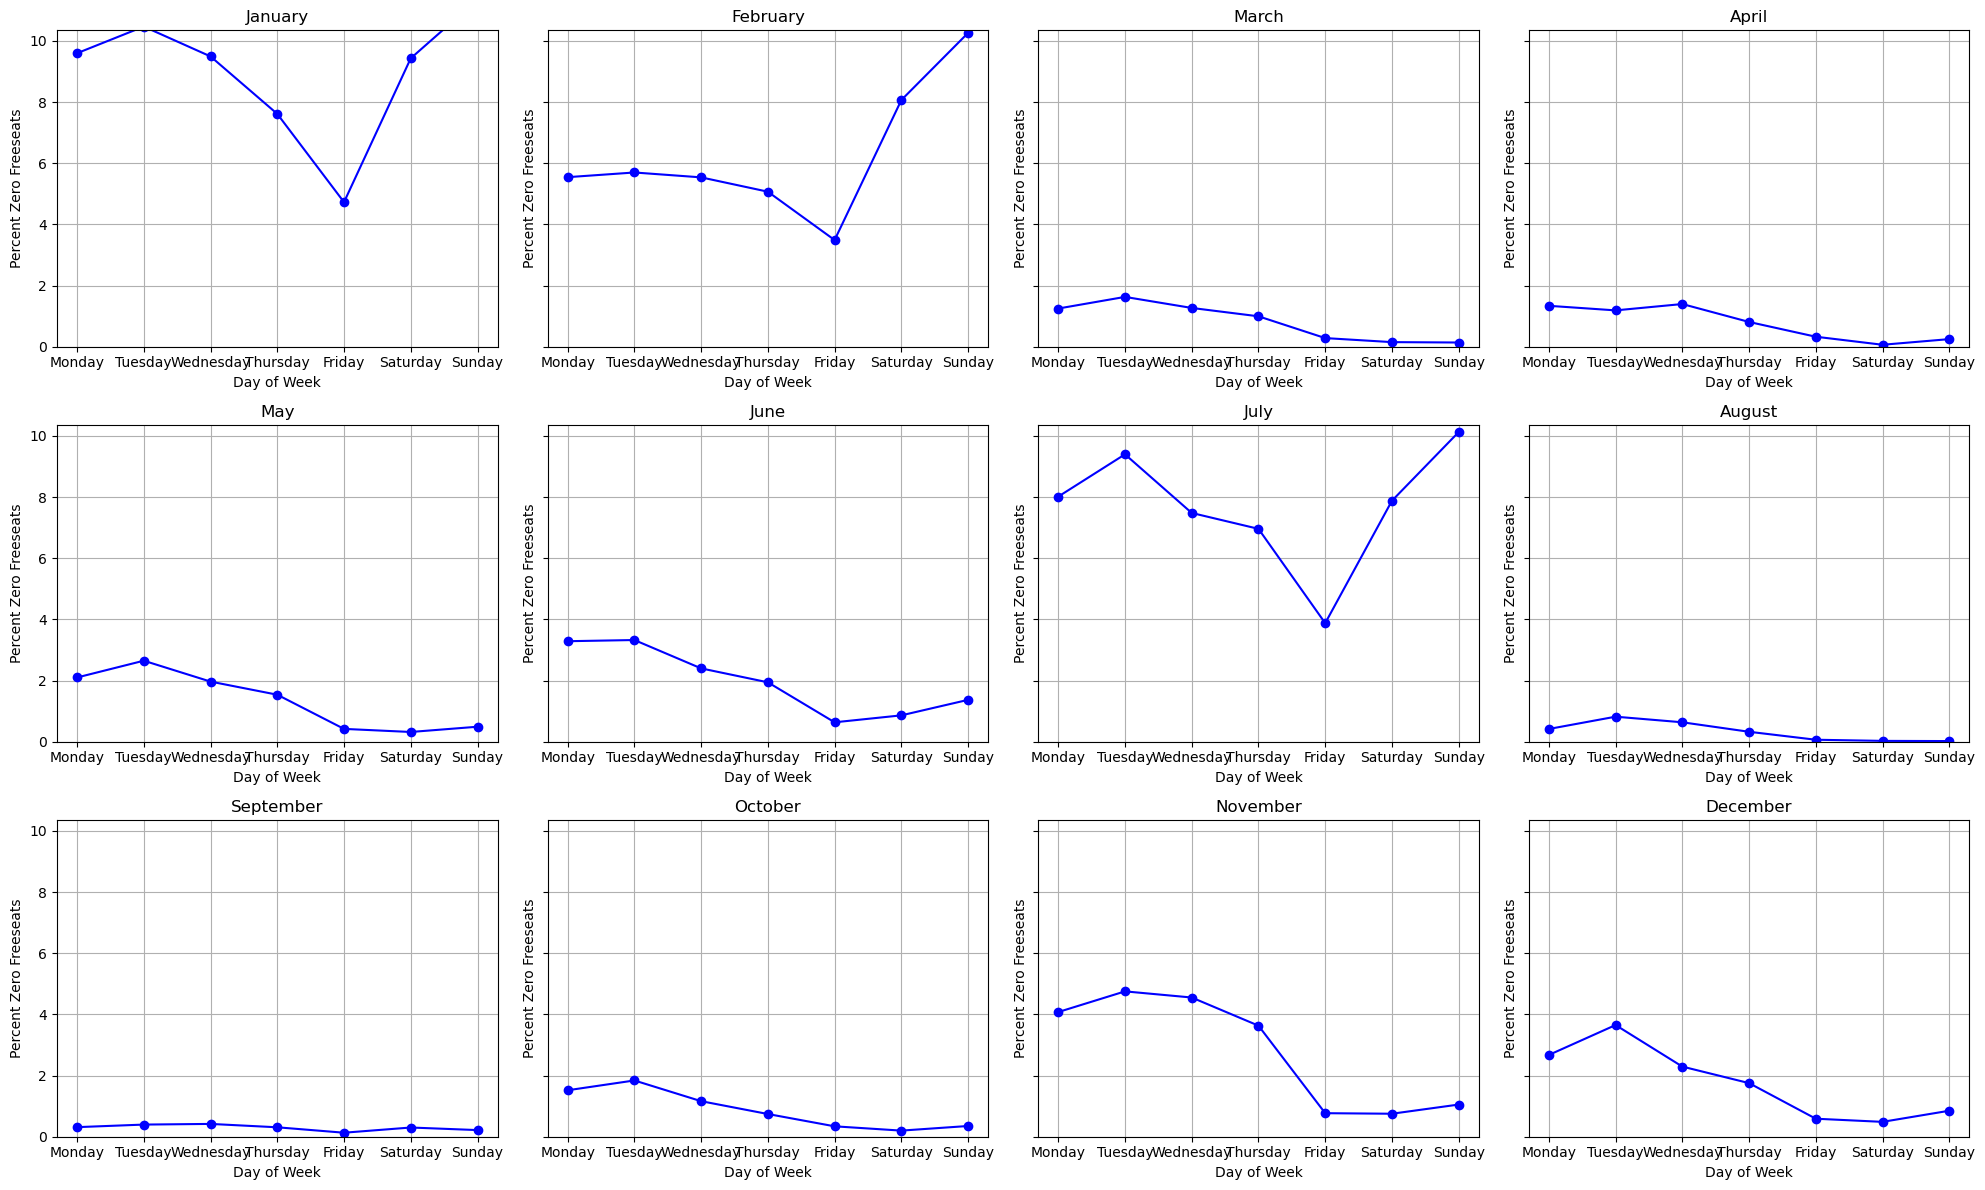

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Copy and prepare data
df = seat_estimates.copy()
df["month"] = df["timestamp"].dt.month
df["day_of_week_num"] = df["timestamp"].dt.weekday  # 0=Monday
df["day_of_week_name"] = df["timestamp"].dt.day_name()

# Compute percentages first to determine global y-axis limits
all_weekly = []
for month in range(1, 13):
    df_month = df[df["month"] == month]
    if df_month.empty:
        continue
    weekly_zero_frac = (
        df_month.groupby(["day_of_week_num", "day_of_week_name"])["freeseats"]
                .apply(lambda x: (x == 0).mean() * 100)
                .reset_index(name="percent_zero_freeseats")
    )
    weekly_zero_frac = weekly_zero_frac.sort_values("day_of_week_num")
    weekly_zero_frac["percent_zero_freeseats_smooth"] = weekly_zero_frac["percent_zero_freeseats"].rolling(3, center=True).mean()
    all_weekly.append(weekly_zero_frac["percent_zero_freeseats_smooth"])

# Determine a good y-axis range
y_min = 0  # start at 0% occupancy
y_max = min(100, max([series.max() for series in all_weekly]) * 1.05)  # small margin above max

# Create 12 subplots (3 rows x 4 columns)
fig, axes = plt.subplots(3, 4, figsize=(20, 12), sharey=True)
axes = axes.flatten()

for month in range(1, 13):
    ax = axes[month - 1]
    
    df_month = df[df["month"] == month]
    if df_month.empty:
        ax.set_title(f"Month {month} (no data)")
        ax.set_ylim(y_min, y_max)
        continue
    
    weekly_zero_frac = (
        df_month.groupby(["day_of_week_num", "day_of_week_name"])["freeseats"]
                .apply(lambda x: (x == 0).mean() * 100)
                .reset_index(name="percent_zero_freeseats")
    )
    weekly_zero_frac = weekly_zero_frac.sort_values("day_of_week_num")
   
    ax.plot(
        weekly_zero_frac["day_of_week_name"],
        weekly_zero_frac["percent_zero_freeseats"],
        marker="o",
        linestyle="-",
        color="blue"
    )
    ax.set_title(pd.to_datetime(f"2023-{month:02d}-01").strftime("%B"))
    ax.set_xlabel("Day of Week")
    ax.set_ylabel("Percent Zero Freeseats")
    ax.set_ylim(y_min, y_max)  # consistent y-axis across all months
    ax.grid(True)

plt.tight_layout()
plt.show()


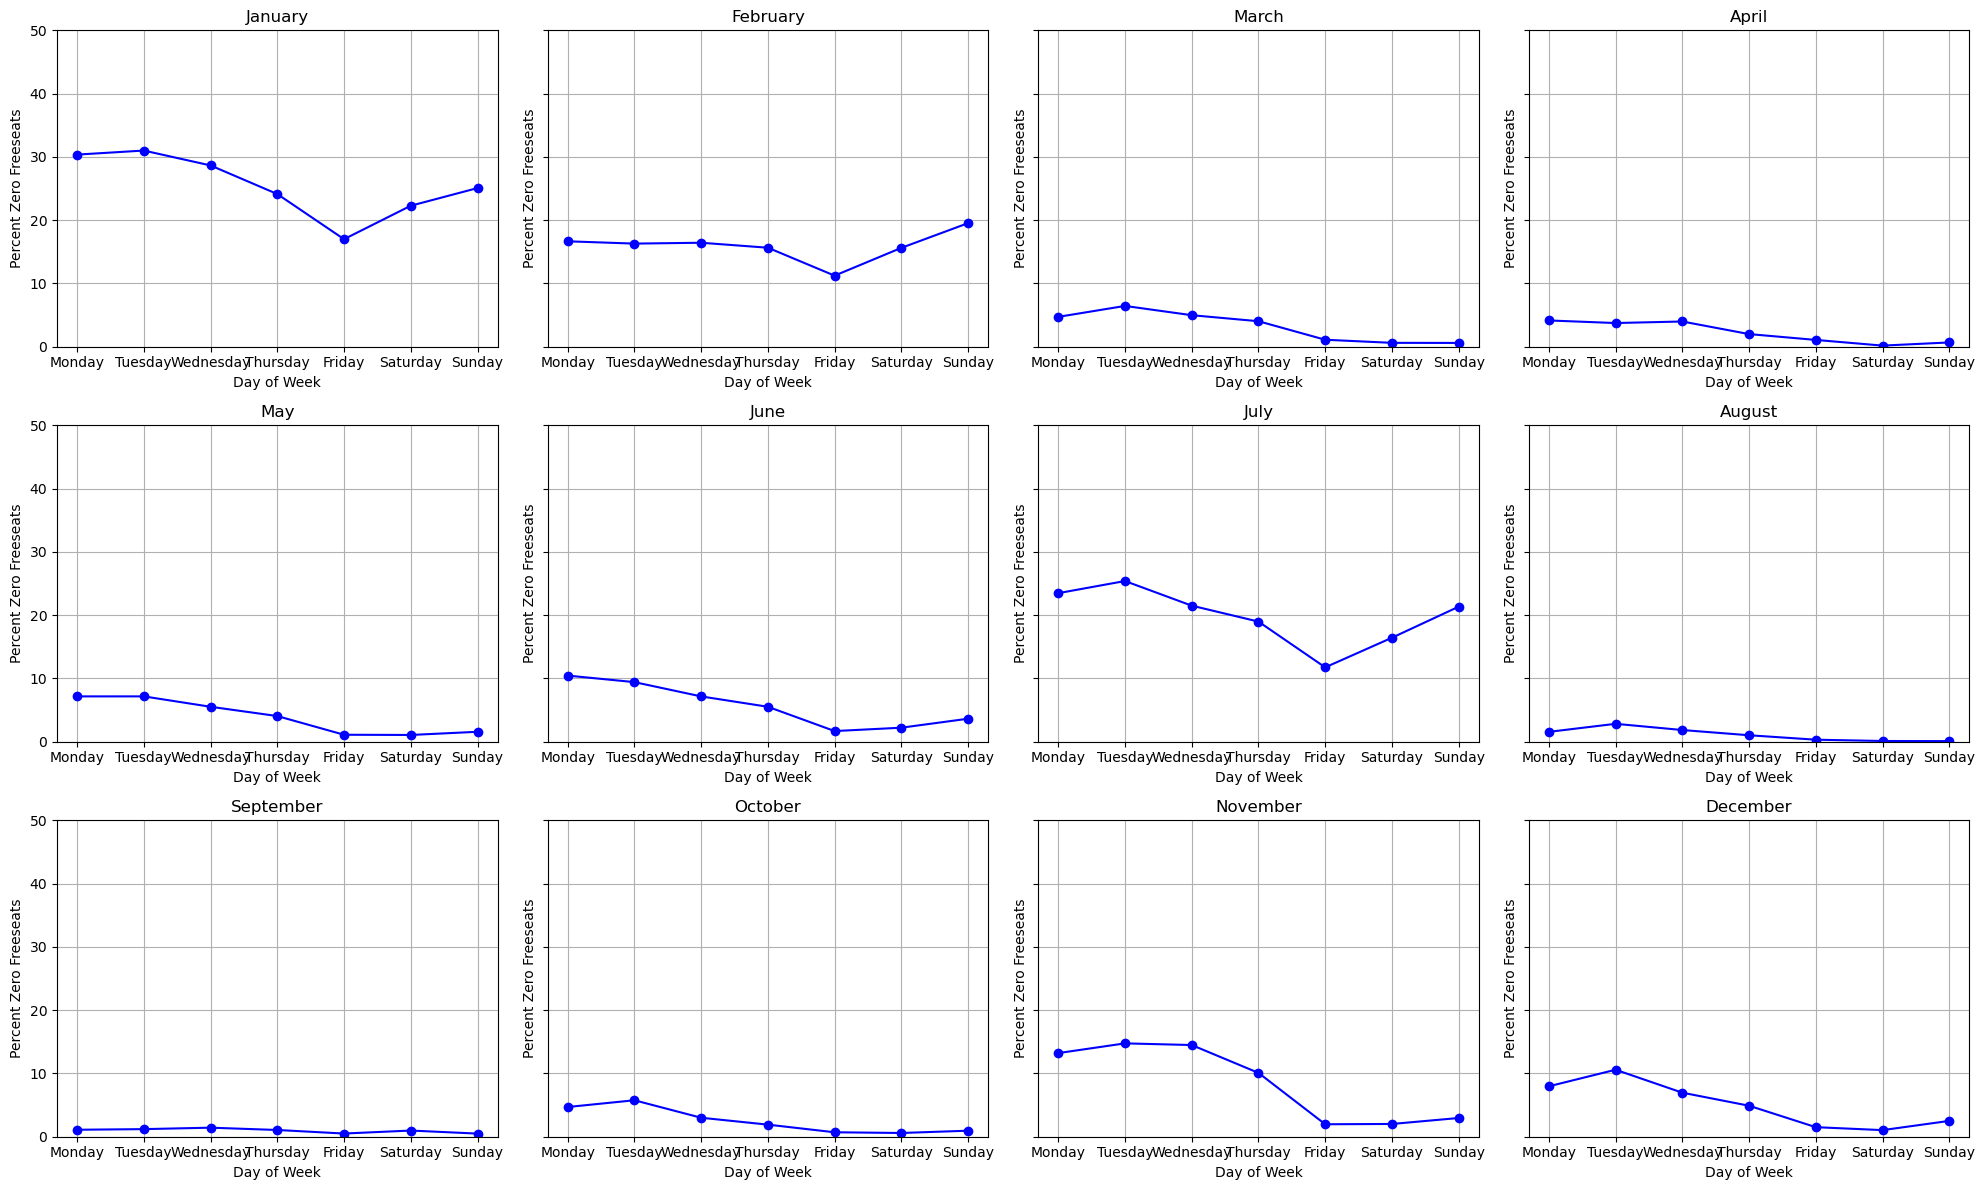

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Copy and prepare data
df = seat_estimates.copy()

# Filter to 10:00–18:00
df = df[(df["timestamp"].dt.hour >= 14) & (df["timestamp"].dt.hour < 16)]

df["month"] = df["timestamp"].dt.month
df["day_of_week_num"] = df["timestamp"].dt.weekday  # 0=Monday
df["day_of_week_name"] = df["timestamp"].dt.day_name()

# Compute percentages first to determine global y-axis limits
all_weekly = []
for month in range(1, 13):
    df_month = df[df["month"] == month]
    if df_month.empty:
        continue
    weekly_zero_frac = (
        df_month.groupby(["day_of_week_num", "day_of_week_name"])["freeseats"]
                .apply(lambda x: (x == 0).mean() * 100)
                .reset_index(name="percent_zero_freeseats")
    )
    weekly_zero_frac = weekly_zero_frac.sort_values("day_of_week_num")
   # weekly_zero_frac["percent_zero_freeseats_smooth"] = weekly_zero_frac["percent_zero_freeseats"].rolling(3, center=True).mean()
   # all_weekly.append(weekly_zero_frac["percent_zero_freeseats_smooth"])
all_weekly.append(weekly_zero_frac["percent_zero_freeseats"])

# Determine a good y-axis range
y_min = 0
y_max = min(100, max([series.max() for series in all_weekly]) * 1.05)

# Create 12 subplots (3 rows x 4 columns)
fig, axes = plt.subplots(3, 4, figsize=(20, 12), sharey=True)
axes = axes.flatten()

for month in range(1, 13):
    ax = axes[month - 1]
    
    df_month = df[df["month"] == month]
    if df_month.empty:
        ax.set_title(f"Month {month} (no data)")
        ax.set_ylim(y_min, y_max)
        continue
    
    weekly_zero_frac = (
        df_month.groupby(["day_of_week_num", "day_of_week_name"])["freeseats"]
                .apply(lambda x: (x == 0).mean() * 100)
                .reset_index(name="percent_zero_freeseats")
    )
    weekly_zero_frac = weekly_zero_frac.sort_values("day_of_week_num")

    ax.plot(
        weekly_zero_frac["day_of_week_name"],
        weekly_zero_frac["percent_zero_freeseats"],
        marker="o",
        linestyle="-",
        color="blue"
    )
    ax.set_title(pd.to_datetime(f"2023-{month:02d}-01").strftime("%B"))
    ax.set_xlabel("Day of Week")
    ax.set_ylabel("Percent Zero Freeseats")
    ax.set_ylim(y_min, 50)
    ax.grid(True)

plt.tight_layout()
plt.show()


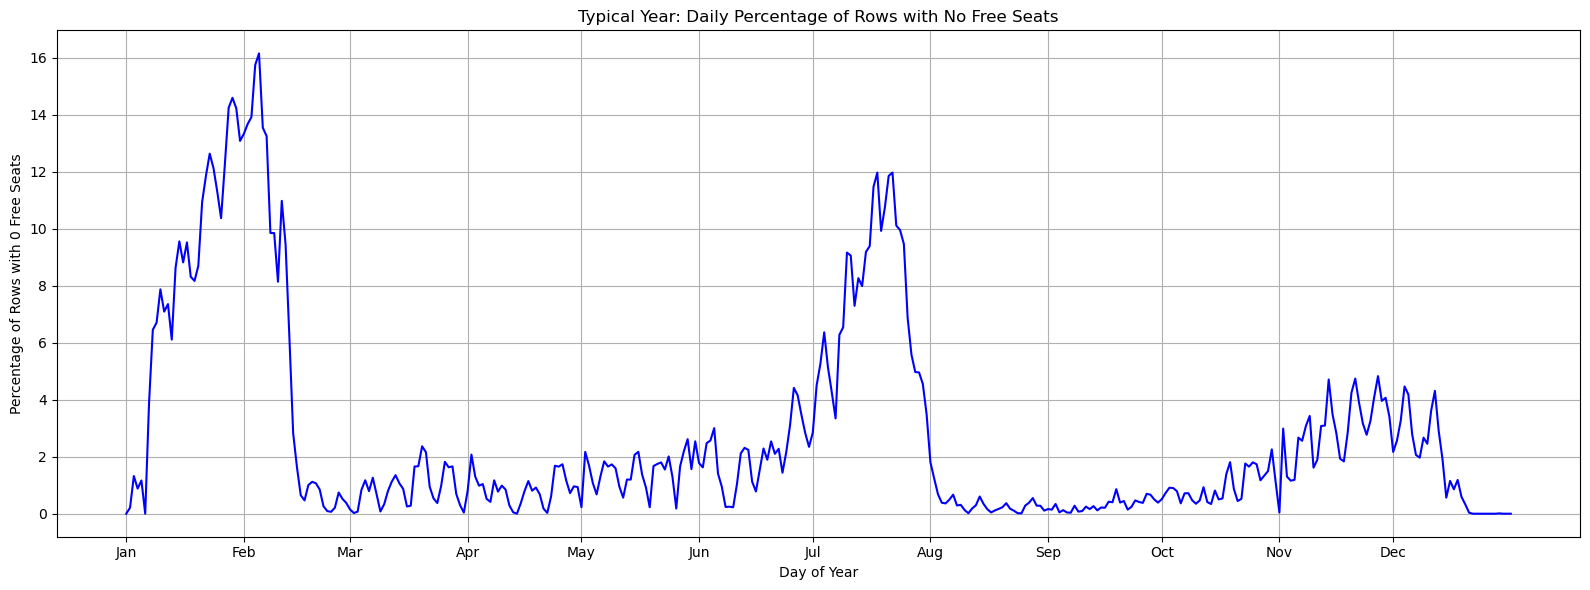

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar

# Copy and prepare data
df = seat_estimates.copy()
df["day_of_year"] = df["timestamp"].dt.dayofyear
df["month"] = df["timestamp"].dt.month

# Compute daily percentage of rows with freeseats == 0, averaged over all years
daily_zero_frac = (
    df.groupby("day_of_year")["freeseats"]
      .apply(lambda x: (x == 0).mean() * 100)
      .reset_index(name="percent_zero_freeseats")
)



# Prepare month labels (first day of each month)
month_starts = df.groupby("month")["day_of_year"].min()
month_labels = [calendar.month_abbr[m] for m in month_starts.index]

# Plot
plt.figure(figsize=(16, 6))
plt.plot(daily_zero_frac["day_of_year"], daily_zero_frac["percent_zero_freeseats"], color="blue")
plt.xlabel("Day of Year")
plt.ylabel("Percentage of Rows with 0 Free Seats")
plt.title("Typical Year: Daily Percentage of Rows with No Free Seats")
plt.xticks(month_starts.values, month_labels)
plt.grid(True)
plt.tight_layout()
plt.show()


# Code that Might Belong Somewhere Else

In [ ]:
# merging the rows of the same building shows that we don't always have the same number of observations for each timestamp
seat_est_aggregated_merged = (
    seat_est_aggregated
    .groupby(["location_id", "timestamp"])
    .agg({
        "id": lambda x: ",".join(sorted(map(str, x))),  # join ids as strings
        "occupiedseats": "sum",
        "freeseats": "sum"
    })
    .reset_index()
)



seat_est_aggregated_merged.head(200)

# Remaining questions

- wtf is Lernzentrum MST (Laura)
- is the Waschhalle data plausible? (Jessica)
- does Waschhalle still have the same seat count? (Jessica)
- how do we choose the cutoff for "critical times of year"? (me)
- is it okay to aggregate data over the years? What happened around covid? (Jessuca)
- is it okay to summarize locations by building? How do we decice that? (that's how we rolll)
- add cofidence to plot
- are we adding confidence intervals to the relative occupancy?
- is the zerofreeseats thing a thing?
- is rounding on 10min okay? --> Andres + Bernado